# Random Background Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [51]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
#     print('Target GC Content: ', true_gc_content)
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [3]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [4]:
def signmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

## Copy Score Files

In [250]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/C57BL6J.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_C57BL6J.pickle ./

In [387]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/BALBCJ.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_BALBCJ.pickle ./

## Read in Score Files

### C57Bl6 Data

In [388]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

### BALBCJ Data

In [396]:
motif_score_BALBCJ_frame= pd.read_pickle('motif_score_frame_BALBCJ.pickle')
motif_sequence_BALBCJ_frame = pd.read_pickle('motif_sequence_frame_BALBCJ.pickle')
motif_strand_BALBCJ_BALBCJ_frame = pd.read_pickle('motif_strand_frame_BALBCJ.pickle')
motif_start_BALBCJ_frame = pd.read_pickle('motif_start_frame_BALBCJ.pickle')
motif_end_BALBCJ_frame = pd.read_pickle('motif_end_frame_BALBCJ.pickle')
motif_count_BALBCJ_frame = pd.read_pickle('motif_count_frame_BALBCJ.pickle')

scaler = preprocessing.MinMaxScaler()
normed_motif_BALBCJ_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_BALBCJ_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_BALBCJ_frame.index = motif_score_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_BALBCJ_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_BALBCJ_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_BALBCJ_motif_frame.index = motif_score_frame.index.values

### Background Data

In [389]:
# read in peak data data
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
strain = 'C57BL6J'
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_'+  strain + '.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_'+  strain + '.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_'+  strain + '.pickle')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_'+  strain + '.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_'+  strain + '.pickle')


In [121]:
# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]

In [122]:
scaler = preprocessing.StandardScaler()
standardized_motif_randomBackground_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
standardized_motif_randomBackground_frame.columns = motif_score_background_frame.columns.values[3:]
standardized_motif_randomBackground_frame.index = motif_score_background_frame.index.values

## Create background peaks from genomic sequences from each chromosome

In [6]:
def getRandomBackground(target_positions, 
                        size_ratio = 1.0, 
                        tolerance = 0.01, 
                        N_threshold = 0.5 ):
    '''
    target_sequences: 2D numpy array, list of genomic coordinates for target sequences [[chr,start,end],...]
    size_ratio: float, number of background sequences relative to target sequences
    tolerance: float, max difference in GC content between True and background labelled samples
    *** Uses mm10 genome taken from Homer ***
    '''
    
    ###load mm10 genome into memory
    
    # index target positions
    # {chr:[]}, value is chromosome length boolean array
    # largest chromosome has 200 million bps 
    _chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
                    'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
                    'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
                    'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    _chrom_size_dict = {}
    _chrom_seq_dict = {}
    for chrom in _chromosomes:
        with open('./mm10_genome/' + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        _chrom_size_dict[chrom] = size
        _chrom_seq_dict[chrom] = seq
    _numChromosomes = len(_chromosomes)
    
    target_chr_position_dict = {x:np.zeros(200000000) for x in _chromosomes} 
    ### initialize target_chr_position_dict using target positions
    ### retreive target sequences
    target_sequences = []
    for pos in target_positions:
        chrom = pos[0]        
        start = pos[1]
        end = pos[2]
        target_chr_position_dict[chrom][start-1:end] = 1 # use 0 indexing of position, versus 1 indexing used in fasta
        seq = _chrom_seq_dict[chrom][start:(end+1)]
        target_sequences.append(seq)
    ### calculate GC content and average length of the target sequences
    target_gc_count = 0
    target_length_count = 0
    for s in target_sequences:
        target_gc_count += s.count('G')
        target_gc_count += s.count('C')
        target_length_count += len(s)
    target_gc_content = target_gc_count/(target_length_count+0.0000001) # GC content of target sequences
    mean_target_length = target_length_count/len(target_sequences) # average length of target sequences
    mean_target_length = int(mean_target_length)
    
    ### select random genomic loci such that they do no overlap target sequences
    numSelected = 0
    numToSelect = len(target_positions) * size_ratio * 2 # candidate pool of background seqs is 2X larger
    candidate_positions = []
    numNallowed = int(N_threshold * mean_target_length) # number of allowable Ns
    counter = 0
    while numSelected < numToSelect:
        if counter % 100000 == 0:
            print(counter, numSelected)
        # select random chromsome
        chromIndex = np.random.randint(_numChromosomes)
        randChrom = _chromosomes[chromIndex]
        randChromSize = _chrom_size_dict[randChrom]
        # must find non overlapping segment on this chromosome before moving on
        selectedSequence = False
        while not selectedSequence:
            counter += 1
            randStart = np.random.randint(randChromSize)
            randEnd = randStart + mean_target_length
            overlap_sum = np.sum(target_chr_position_dict[randChrom][randStart:(randEnd + 1)])
            
            if not overlap_sum > 0:
                randSeq = _chrom_seq_dict[randChrom][randStart:(randEnd+1)]
                numN = randSeq.count('N')
                if numN <= numNallowed:
                    rand_gc_count = randSeq.count('G')+ randSeq.count('C')
                    rand_gc = rand_gc_count/mean_target_length
                    if abs(target_gc_content - rand_gc) <= tolerance:
                        selectedSequence = True
                        numSelected+=1
                        candidate_positions.append([randChrom, randStart, randEnd, randSeq])
    # calcuate GC content of background samples
    background_gc_count = 0
    background_length = 0
    for cp in candidate_positions:
        s = cp[3]
        background_gc_count += s.count('G')
        background_gc_count += s.count('C')
        background_length += len(s)
    background_gc_content = background_gc_count/(background_length+0.0000001)
    print(target_gc_content,background_gc_content)
    return candidate_positions

In [234]:
# generate random genomic background for all monomers
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_positions = summary_frame[summary_frame.index.isin(target_indices)][['chr', 'start', 'end']].values
        start = time.time()
        backgroundPositions = getRandomBackground(target_positions, N_threshold =1.0, tolerance=0.05, size_ratio=5)
        end = time.time()
        print(monomer, treatment, end - start)
        pickle.dump(backgroundPositions,open('./background_pickles/' + monomer + '_' + treatment + '_background.pickle', 'wb'))

### Background positions to create peak files


In [26]:
strain = 'c57bl6'
! if [ ! -d ./background_peak_files ]; then mkdir ./background_peak_files; fi
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        backgroundPositions = pickle.load(open('./background_pickles/' + monomer + '_' + treatment + '_background.pickle', 'rb'))
        outFile = open('./background_peak_files/' + strain + '_' + monomer + '_' + treatment + '-background_peaks.tsv' , 'w')
        outFile.write('\t'.join(['#PeakID','chr','start','end','strand','idrScore', 'count','\n']))
        counter = 0
        for pos in backgroundPositions:
            chrom = pos[0]
            start = str(pos[1])
            end = str(pos[2])
            strand = '+' # arbitrary - for compatibility with downstream scripts
            score = '1' # arbitrary - for compatibility with downstream scripts
            randID = 'background_' + str(np.random.randint(10000)) + '_' + str(counter)
            counter += 1
            outFile.write('\t'.join([randID, chrom, start, end, strand, score, score, '\n']))
        outFile.close()
        
    

### Merge Peak Files

In [27]:
%%capture
! mergePeaks -d given ./background_peak_files/*tsv > ./background_merged_peaks.tsv


In [28]:
! makeSummaryFile.py ./background_merged_peaks.tsv ./background_group_summary.tsv ./background_peak_files/*

sys:1: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
Finished reading merged peak file...
Integrating scores for c57bl6_atf3_kla-background
Integrating scores for c57bl6_atf3_veh-background
Integrating scores for c57bl6_cjun_kla-background
Integrating scores for c57bl6_cjun_veh-background
Integrating scores for c57bl6_fos_kla-background
Integrating scores for c57bl6_fos_veh-background
Integrating scores for c57bl6_junb_kla-background
Integrating scores for c57bl6_junb_veh-background
Integrating scores for c57bl6_jund_kla-background
Integrating scores for c57bl6_jund_veh-background


In [9]:
# read in peak data data
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### create a script to scan for motifs using FIMO



In [29]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

In [37]:
%%bash
perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains C57BL6J -file ./background_merged_peaks.tsv -output ./peak_sequences/C57BL6J_marge.fa





Saving peaks
Loading shift vectors


In [39]:
# reformat fastq files to use homer peak IDs

coordinate_peakID_dict = {} # {chr_start_end:homerID}
with open ('./background_merged_peaks.tsv') as f:
    data = f.readlines()
for line in data[1:]:
    tokens = line.split('\t')
    coordinate = '_'.join(tokens[1:4])
    peakID = tokens[0].strip()
    coordinate_peakID_dict[coordinate] = tokens[0]



In [40]:
for fastaFile in os.listdir('./peak_sequences/'):
    if 'marge' in fastaFile:
        strain = fastaFile.split('_')[0]
        outFile = open('./peak_sequences/' + fastaFile.replace('_marge',''), 'w')
        print(fastaFile)
        with open('./peak_sequences/' + fastaFile) as f:
            data = f.readlines()
        for line in data:
            if '>' in line:
                coordinate = line[1:].replace('_'+strain,'').strip()
                
                peakID = coordinate_peakID_dict[coordinate]
                outFile.write('>' + peakID + '\n')
               
            else:
                outFile.write(line)
        outFile.close()

C57BL6J_marge.fa


In [252]:
!cp ./peak_sequences/C57BL6J.fa ./C57BL6J_background.fa

In [63]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jtao/analysis/random_background_analysis/fimo_results/ ]; then mkdir /home/jtao/analysis/random_background_analysis/fimo_results/; fi
! if [ ! -d /home/jtao/analysis/random_background_analysis/fimo_out/ ]; then mkdir /home/jtao/analysis/random_background_analysis/fimo_out/; fi
! rm -rf ./fimo_out/*
! rm -rf ./fimo_result/*


pthresh = 0.01
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]
        count = 0
        scriptFile = open('scanMotifs_background_'+ strain +'.sh','w')
        for m in os.listdir(motif_dir):
            if 'fimo' in m:
                fimo_out_dir = './fimo_out/' + strain + '_' +m.replace('.fimo','')
                outPath = fimo_results_dir + '/' +strain + '_' + m.replace('.fimo','') +'.txt'
                scriptFile.write(
                    '(sleep ' + str(15 * count) + 
                    's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                    str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
                    motif_dir + '/' + m + ' ./peak_sequences/' + fastaFile +
                    '> ' + outPath + ' ) & \n')
                count+=1
        scriptFile.close()




C57BL6J.fa


In [ ]:
%%bash
chmod a+x ./scanMotifs*.sh
for i in ./scanMotifs*sh; 
    do echo 'sleeping...';
    echo $i;
    $i;
#     sleep 5m;
done



### Read in Motif Scores

In [ ]:
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]

        peak_start_dict = dict(zip(summary_background_frame['ID'].values, summary_background_frame['start'].values))

        motif_score_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_score_background_frame.index=motif_score_background_frame['ID'].values

        motif_sequence_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_sequence_background_frame.index=motif_score_background_frame['ID'].values

        motif_strand_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_strand_background_frame.index=motif_score_background_frame['ID'].values

        motif_start_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_start_background_frame.index=motif_score_background_frame['ID'].values

        motif_end_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_end_background_frame.index=motif_score_background_frame['ID'].values

        motif_count_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_count_background_frame.index = motif_count_background_frame['ID'].values

        counter=0
        for m in sorted(os.listdir(motif_dir)):
            counter+=1
            if '.fimo' in m:
                print(counter,m)
                motif_results = './fimo_results/' + strain + '_' + m.replace('.fimo','') +'.txt'
                fimo_result_background_frame=pd.read_csv(motif_results, 
                                              skiprows=1,
                                              names=['motif_name', 
                                                     'peak_id', 
                                                     'start', 
                                                     'stop', 
                                                     'strand', 
                                                     'score', 
                                                     'pvalue', 
                                                     'sequence'],
                                              sep='\t')
                motif_name = m.replace('.fimo','')

                id_count_dict = {} #{PeakID:motifCount}
                id_values_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}

                ids = fimo_result_background_frame['peak_id'].values
                scores = fimo_result_background_frame['score'].values
                strands = fimo_result_background_frame['strand'].values
                sequences = fimo_result_background_frame['sequence']
                starts = fimo_result_background_frame['start']
                ends = fimo_result_background_frame['stop']

                for i in range(len(ids)):
                    currentScore = float(scores[i])
                    currentSequence = sequences[i]
                    currentStrand = strands[i]
                    currentStart = int(starts[i])
                    currentEnd = int(ends[i])

                    if currentScore < 0.0:
                        currentScore = 0.0
                    
                    
                    values = (currentScore, currentSequence, currentStrand, currentStart, currentEnd)

                    if ids[i] in id_values_dict:
                        if currentScore > id_values_dict[ids[i]][0]:
                            id_values_dict[ids[i]] = values
                            id_count_dict[ids[i]] += 1
                    else:
                        id_values_dict[ids[i]] = values
                        id_count_dict[ids[i]] = 1

                sorted_values = [id_values_dict[x] if x in id_values_dict else (0,'','?',-1,-1,0) for x in  motif_score_background_frame['ID'].values]
                sorted_scores = [x[0] for x in sorted_values]
                sorted_sequences = [x[1] for x in sorted_values]
                sorted_strands = [x[2] for x in sorted_values]
                sorted_starts = [x[3] for x in sorted_values]
                sorted_ends = [x[4] for x in sorted_values]
                sorted_counts = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_score_background_frame['ID'].values]

                motif_score_background_frame[motif_name] = sorted_scores
                motif_sequence_background_frame[motif_name] = sorted_sequences
                motif_strand_background_frame[motif_name] = sorted_strands
                motif_start_background_frame[motif_name] = sorted_starts
                motif_end_background_frame[motif_name] = sorted_ends
                motif_count_background_frame[motif_name] = sorted_counts


        motif_score_background_frame.to_pickle('motif_score_background_frame_'+  strain + '.pickle')
        motif_score_background_frame.to_csv('motif_scores_'+  strain + '.tsv', sep='\t', index=False)

        motif_sequence_background_frame.to_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
        motif_sequence_background_frame.to_csv('motif_sequence_'+  strain + '.tsv', sep='\t', index=False)

        motif_strand_background_frame.to_pickle('motif_strand_background_frame_'+  strain + '.pickle')
        motif_strand_background_frame.to_csv('motif_strand_'+  strain + '.tsv', sep='\t', index=False)

        motif_start_background_frame.to_pickle('motif_start_background_frame_'+  strain + '.pickle')
        motif_start_background_frame.to_csv('motif_start_background_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_end_background_frame.to_pickle('motif_end_background_frame_'+  strain + '.pickle')
        motif_end_background_frame.to_csv('motif_end_background_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_count_background_frame.to_pickle('motif_count_background_frame_'+  strain + '.pickle')
        motif_count_background_frame.to_csv('motif_count_background_frame_'+  strain + '.tsv', sep='\t', index=False)



## Run Classifier using Open Chromatin Background

In [52]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
test_size = 0.8
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [53]:

# for monomers using all motifs
strain = 'c57bl6'
factor_auc_dict = {}
factor_precision_dict = {}
factor_coeff_dict = {}
factor_prob_dict = {}
factor_meanCoeff_dict = {}
factor_intercept_dict = {}
factor_meanIntercept_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)][strain + '_' + monomer + '_' + treatment] > 0.0
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_dict[monomer + '_' + treatment] = all_intercepts
            factor_meanIntercept_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.832027823015 1.40519614985e-06 precision: 0.706484731905 2.03184009061e-06 numTestPositives: 17575
cjun_veh roc: 0.805465729082 1.93345838302e-06 precision: 0.46280774548 1.66540966928e-06 numTestPositives: 10125
fos_veh roc: 0.838099628864 1.53526856337e-05 precision: 0.320347365018 2.94270817102e-05 numTestPositives: 1598
junb_veh roc: 0.642582009548 0.000223027252849 precision: 0.0179831424139 3.51794167446e-06 numTestPositives: 382
jund_veh roc: 0.802998908058 1.01653489646e-06 precision: 0.560064310855 1.24356725515e-06 numTestPositives: 14495
atf3_kla roc: 0.828123000139 3.08005725446e-06 precision: 0.800281389227 8.12616722565e-06 numTestPositives: 27801
cjun_kla roc: 0.801471628805 8.97099826247e-07 precision: 0.47365656171 6.04360519473e-07 numTestPositives: 12949
fos_kla roc: 0.827997142178 7.92787873747e-07 precision: 0.656560334401 6.81595029957e-06 numTestPositives: 17262
junb_kla roc: 0.822788587275 1.53648860505e-06 precision: 0.470662626593 2.34345311066

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


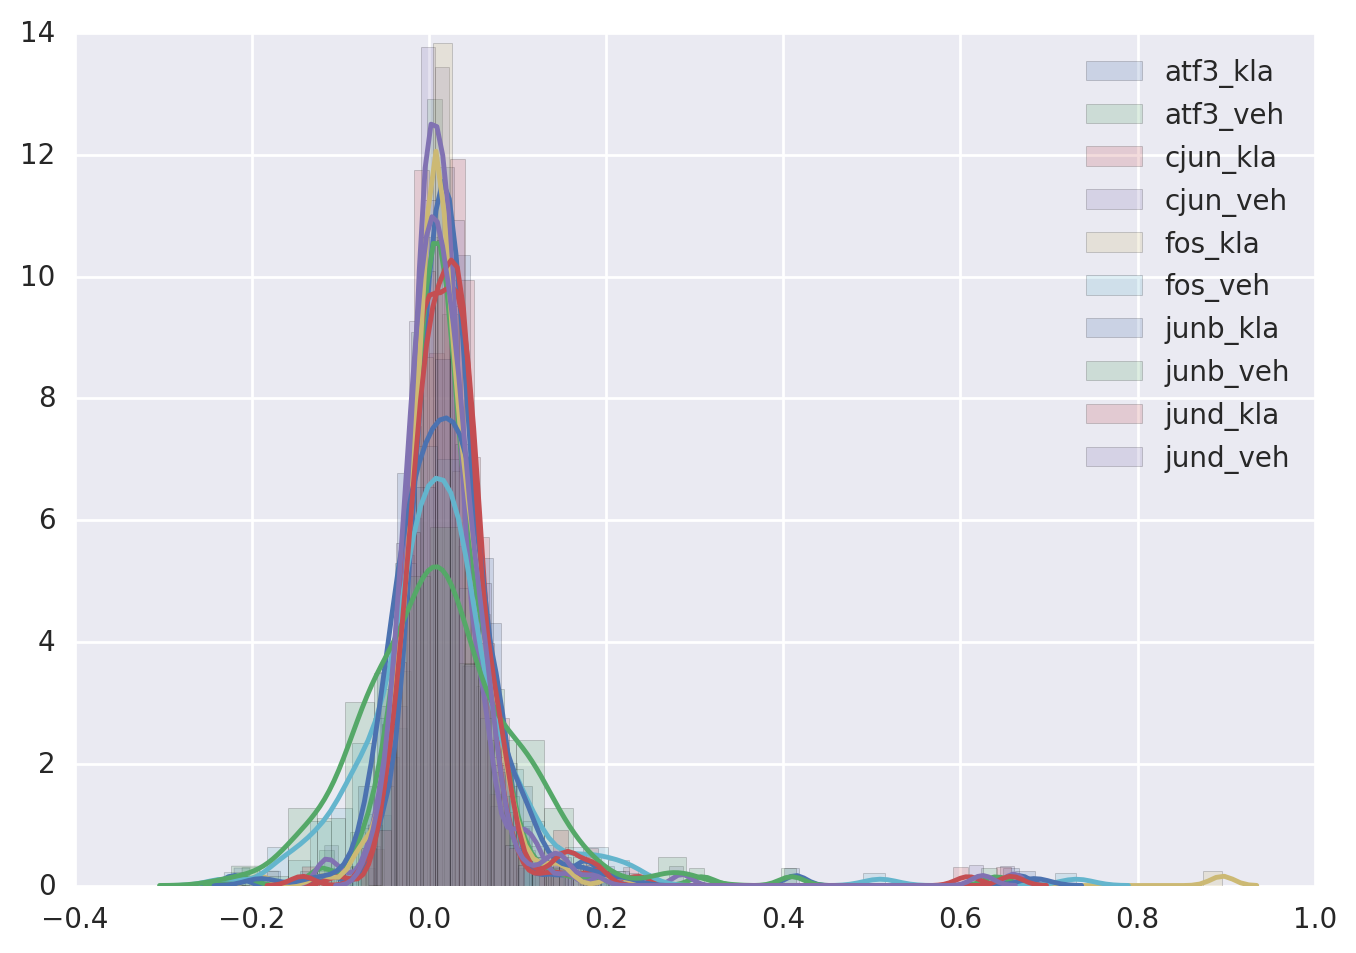

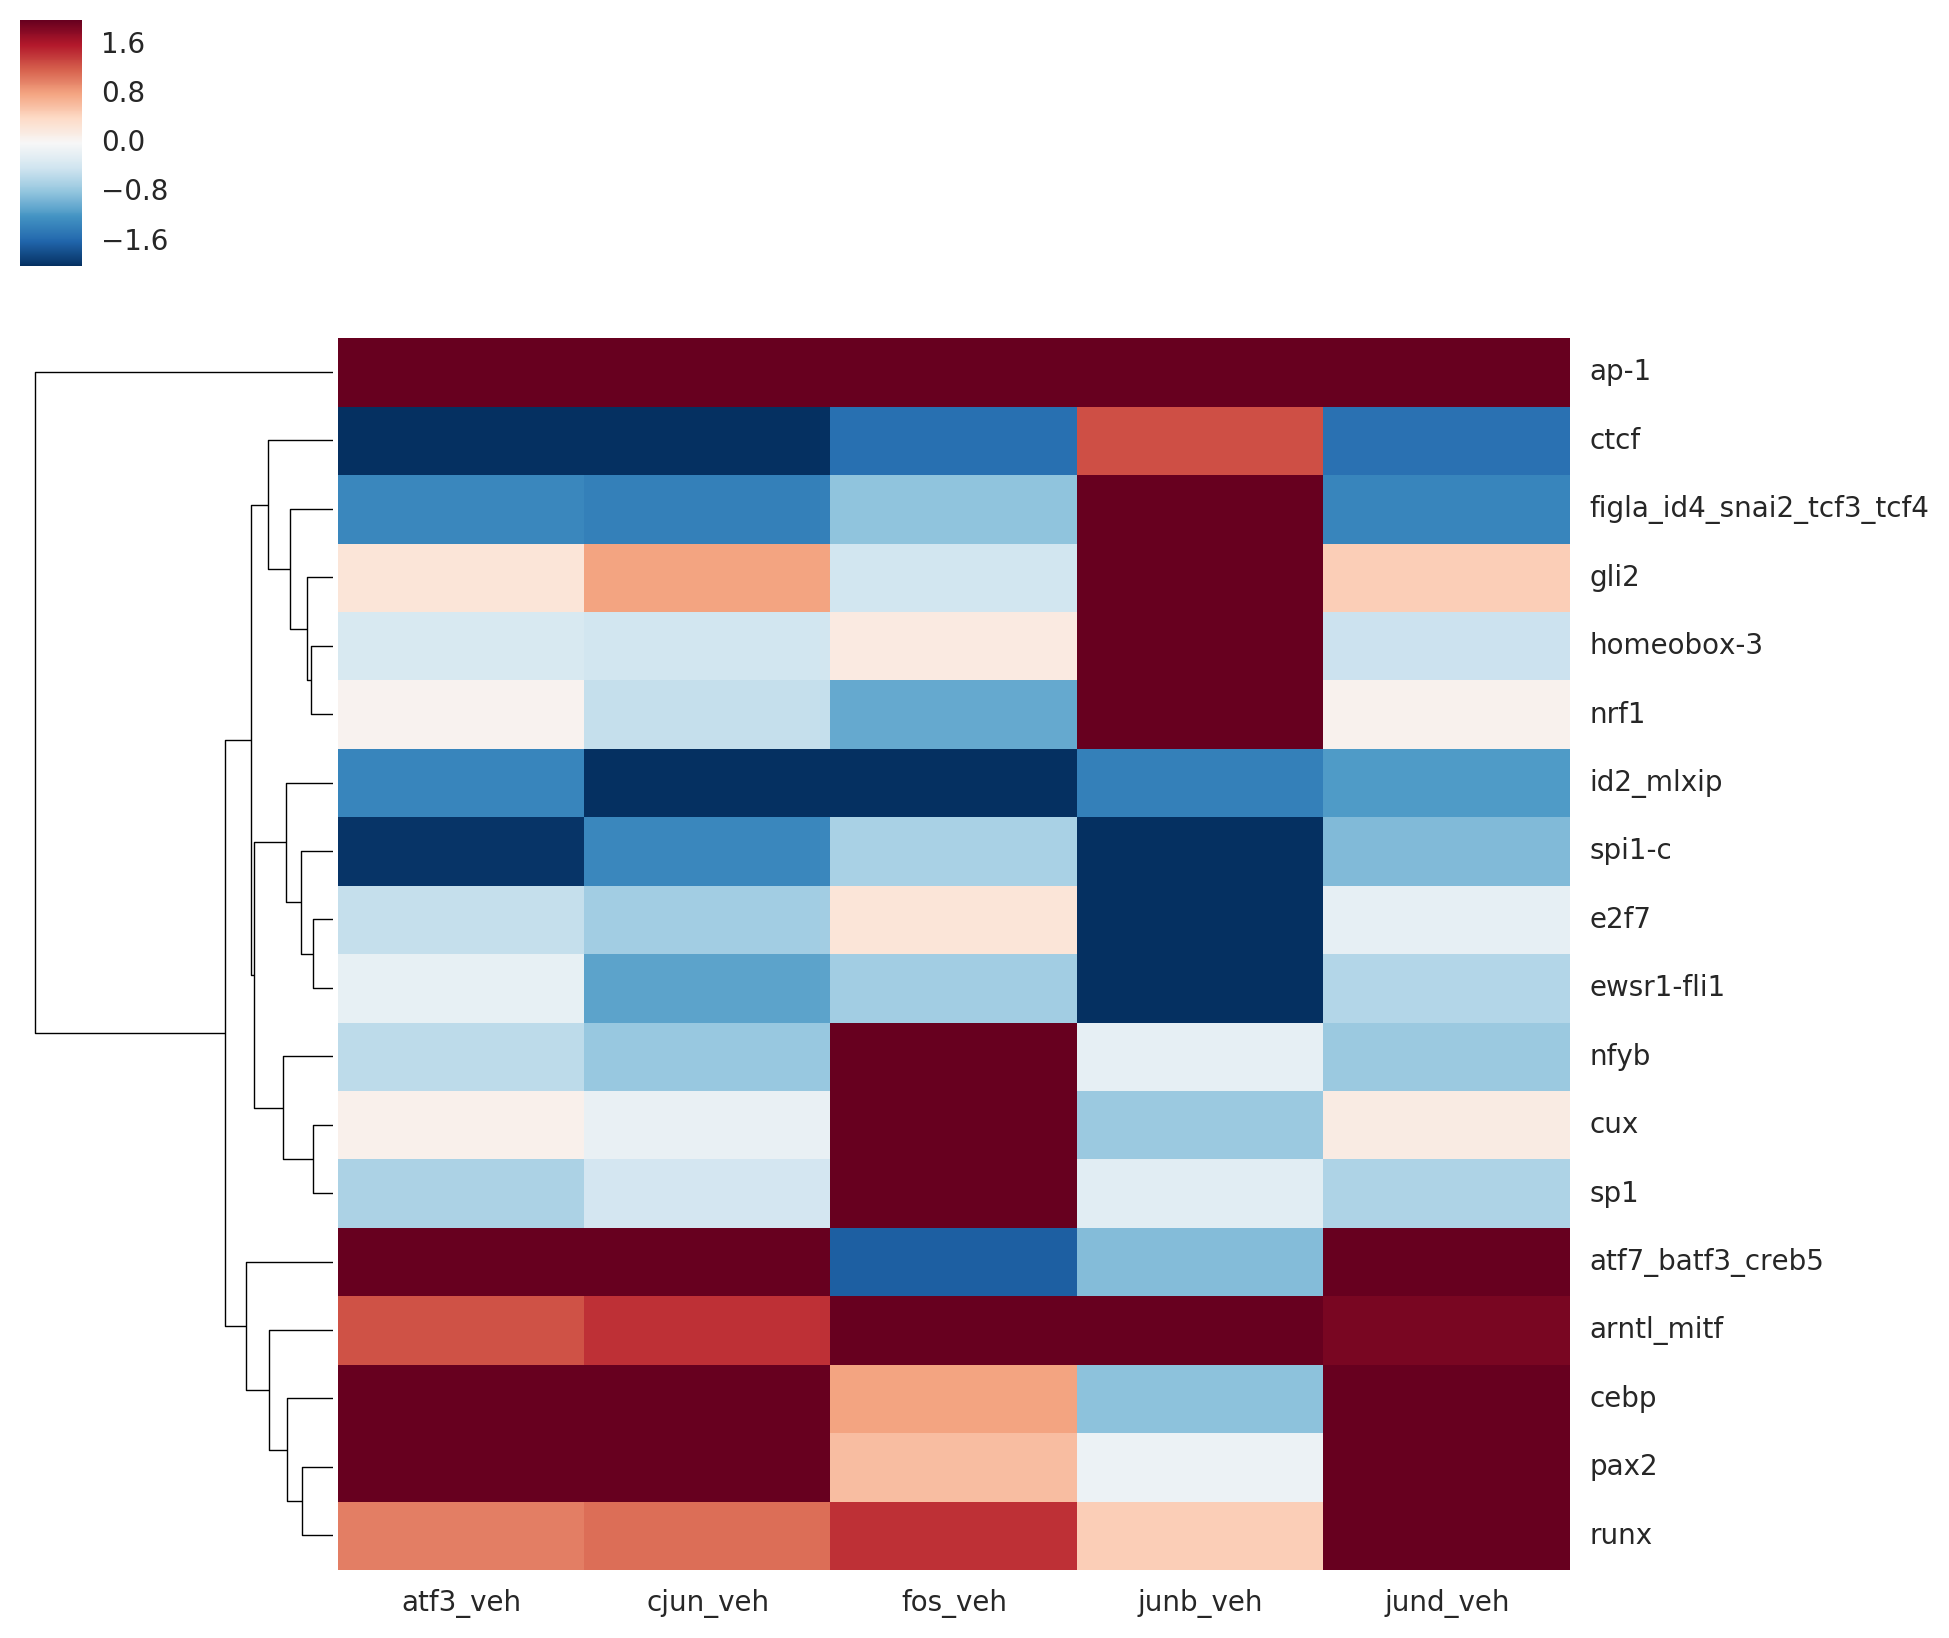

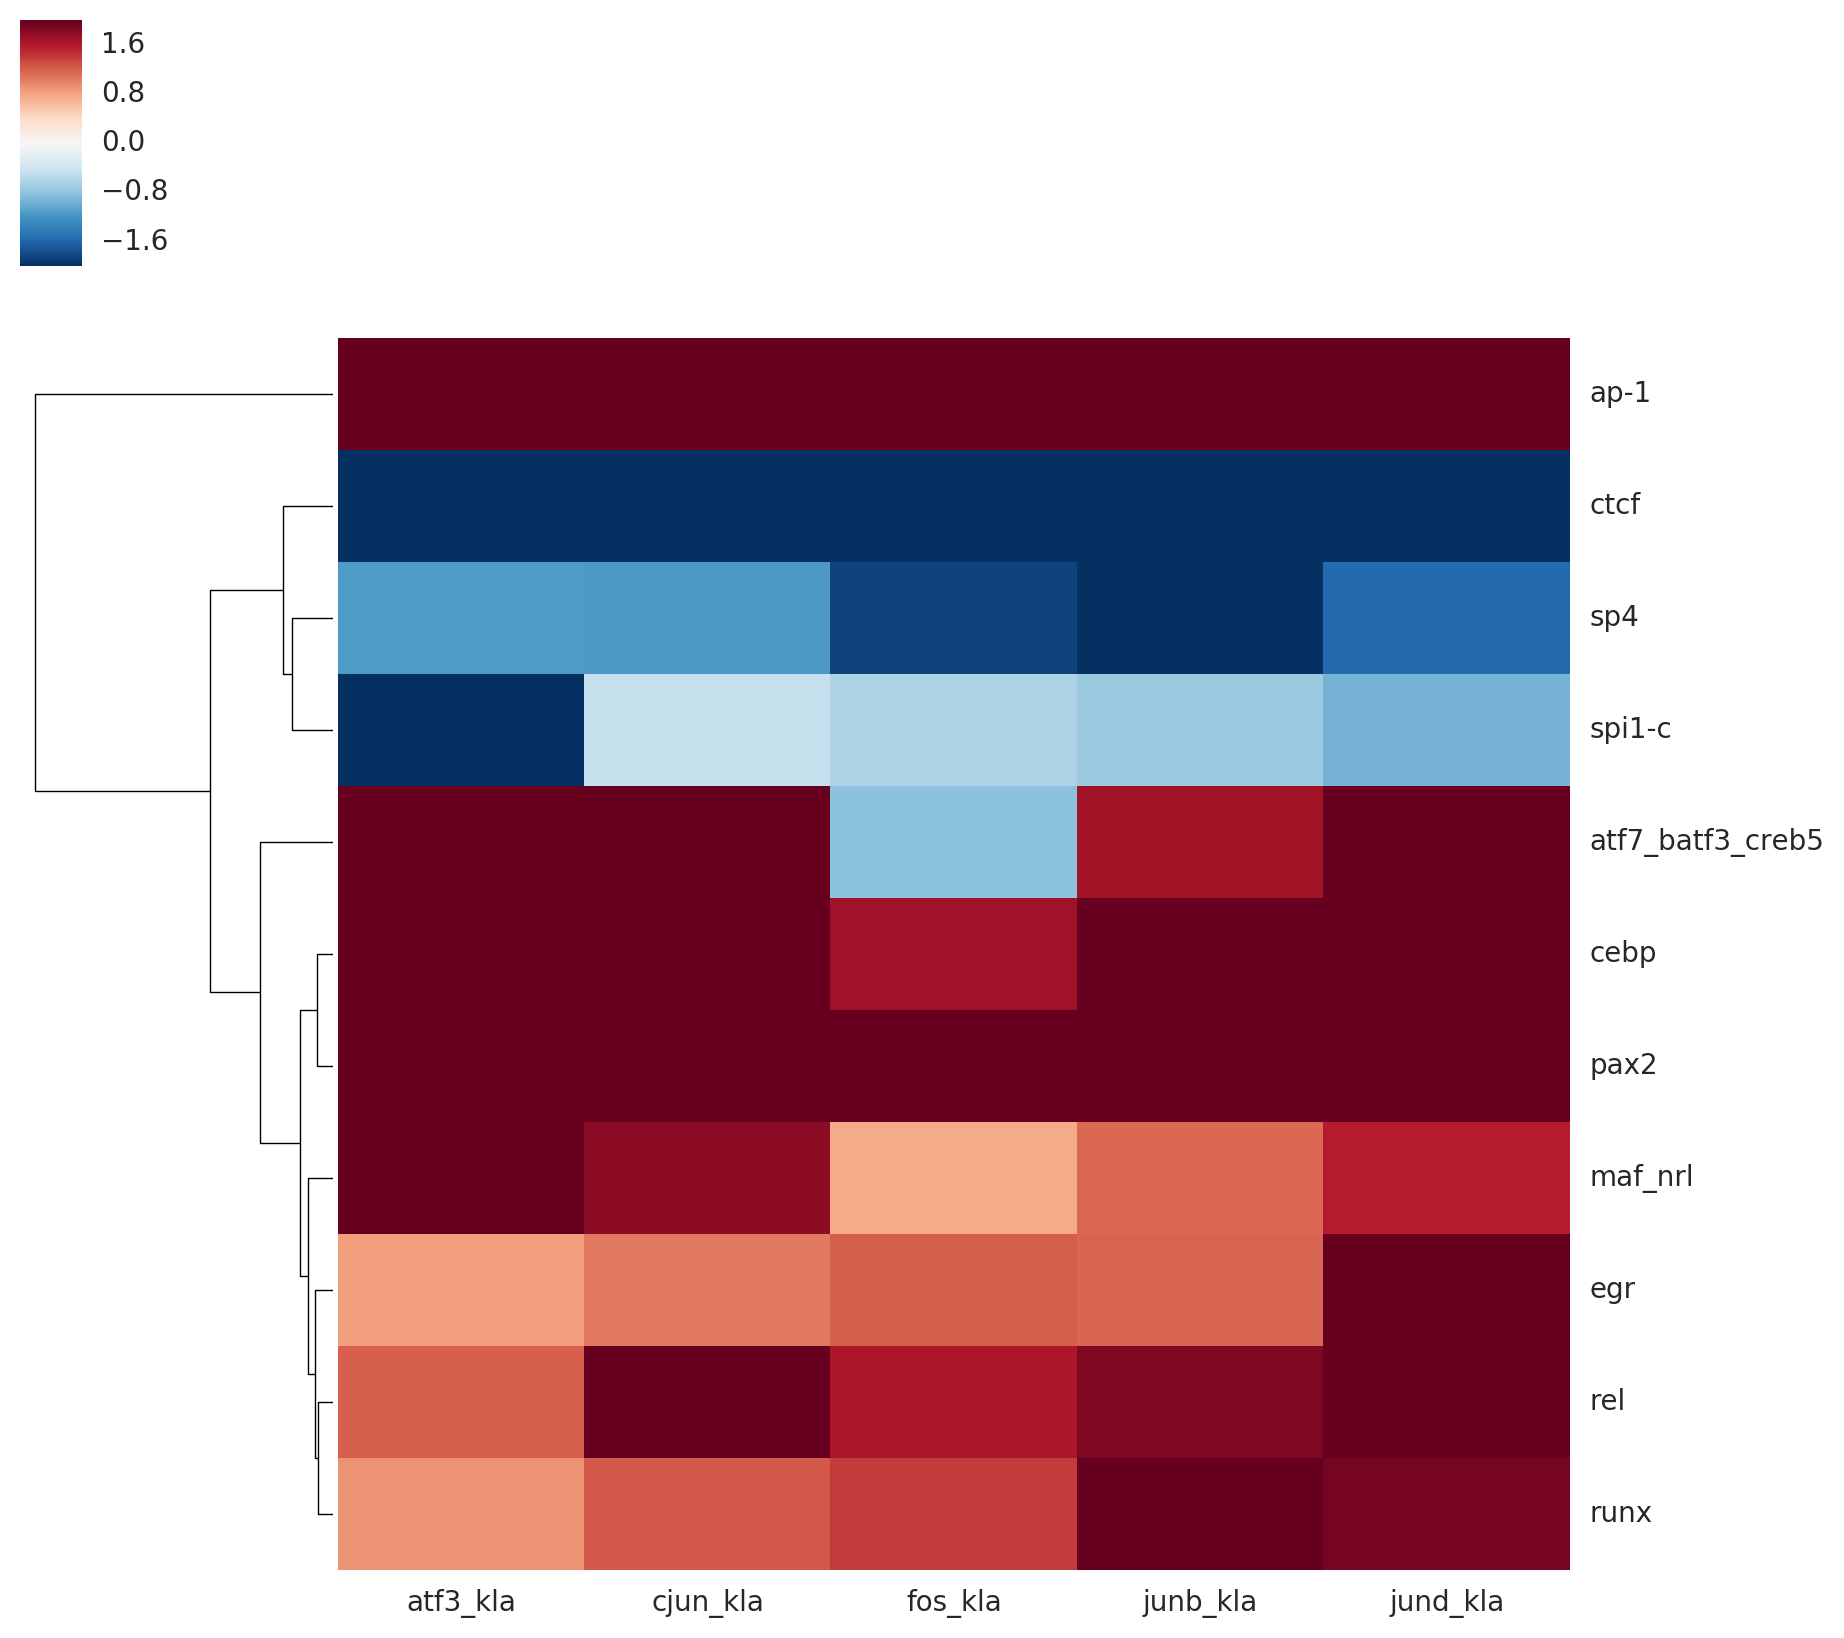

In [54]:
coefficients_frame = pd.DataFrame(factor_meanCoeff_dict)
coefficients_frame.index = standardized_motif_frame.columns.values
for col in coefficients_frame.columns.values:
    sns.distplot(coefficients_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_frame = coefficients_frame[[]]
for col in coefficients_frame:
    coefficients_zscore_frame[col] = scipy.stats.mstats.zscore(coefficients_frame[col].values)

coefficients_zscore_frame.index = coefficients_frame.index.values
coefficients_zscore_frame.columns = coefficients_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 2.0

for treatment in ['veh', 'kla']:
    data = coefficients_zscore_frame
    data = data[[x for x in coefficients_zscore_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );





## Run Logistic Regression using Random Genomic Background

In [120]:
strain = 'C57BL6J'
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_'+  strain + '.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_'+  strain + '.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_'+  strain + '.pickle')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_'+  strain + '.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_'+  strain + '.pickle')


In [121]:
# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]







In [122]:
scaler = preprocessing.StandardScaler()
standardized_motif_randomBackground_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
standardized_motif_randomBackground_frame.columns = motif_score_background_frame.columns.values[3:]
standardized_motif_randomBackground_frame.index = motif_score_background_frame.index.values

In [126]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [339]:
# for monomers using all motifs
strain = 'c57bl6'
factor_auc_randomBackground_dict = {}
factor_precision_randomBackground_dict = {}
factor_coeff_randomBackground_dict = {}
factor_prob_randomBackground_dict = {}
factor_meanCoeff_randomBackground_dict = {}
factor_intercept_randomBackground_dict = {}
factor_meanIntercept_randomBackground_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
#         background_indices = motif_score_background_frame.index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_randomBackground_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_randomBackground_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_randomBackground_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_randomBackground_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_randomBackground_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_randomBackground_dict[monomer + '_' + treatment] = all_intercepts
            factor_meanIntercept_randomBackground_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:59: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.917037545312 2.89102532975e-06 precision: 0.917035703761 3.15590827868e-06 numTestPositives: 11013
cjun_veh roc: 0.936968580735 4.69696453587e-07 precision: 0.937860235788 3.85339270197e-07 numTestPositives: 6335
fos_veh roc: 0.937472926088 2.87239881136e-06 precision: 0.937891161315 9.74859106122e-06 numTestPositives: 994
junb_veh roc: 0.771138684456 0.000455867041404 precision: 0.787244448966 0.000273100637346 numTestPositives: 247
jund_veh roc: 0.916355112069 2.5437354241e-06 precision: 0.914974032581 9.05141462344e-06 numTestPositives: 9025
atf3_kla roc: 0.912818038838 4.66832323232e-07 precision: 0.90613210681 6.97205541824e-07 numTestPositives: 17327
cjun_kla roc: 0.934028486853 1.71418299379e-06 precision: 0.931458777044 3.5008533335e-06 numTestPositives: 8068
fos_kla roc: 0.937545311505 6.91129857761e-07 precision: 0.934305763555 8.71795096907e-07 numTestPositives: 10733
junb_kla roc: 0.947222973028 1.30087564492e-06 precision: 0.946688439655 6.90399884175e-07 n

### Logistic Regression using Counts and Top Motif Score

In [128]:
# for monomers using motif counts and best motif score
strain = 'c57bl6'
factor_coeff_dict_affinityCount = {}
factor_auc_dict_affinityCount = {}
factor_precision_dict_affinityCount = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                    affinity_features, labels, test_size = test_size)
                
                training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                     motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
                test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])
                #  Train affinity classifier
                affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                affinity_classifier.fit(training_affinity_features, training_labels)
                
                # Train count classifier
                count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                count_classifier.fit(training_count_features, training_labels)
                
                # train combined classifier
                training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
                training_count_scores = count_classifier.decision_function(training_count_features)
                training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                                 'Count':training_count_scores})
                combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                combined_classifier.fit(training_combined_features, training_labels)

                # retrieve test probabilities
                test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
                test_count_scores = count_classifier.decision_function(test_count_features)
                test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                           'Count':test_count_scores})
                probas = combined_classifier.predict_proba(test_combined_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])

            factor_auc_dict_affinityCount[monomer + '_' + treatment] = all_aucs
            factor_precision_dict_affinityCount[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict_affinityCount[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.949691064115 4.67072946517e-07 precision: 0.947381396559 8.50871343478e-07 numTestPositives: 11013
cjun_veh roc: 0.958410441983 2.90365511424e-06 precision: 0.95911847189 3.29760630723e-06 numTestPositives: 6335
fos_veh roc: 0.951479703169 1.61710600429e-06 precision: 0.952769448177 6.73539916143e-07 numTestPositives: 994
junb_veh roc: 0.807584126932 0.000242839070957 precision: 0.820909566532 0.000233732343506 numTestPositives: 247
jund_veh roc: 0.947984466663 4.51207406284e-06 precision: 0.945506966102 5.19441810948e-06 numTestPositives: 9025
atf3_kla roc: 0.948146567802 2.54075627241e-07 precision: 0.944388414901 3.17294324296e-07 numTestPositives: 17327
cjun_kla roc: 0.958668129587 1.30564674138e-06 precision: 0.956760498272 1.60916610343e-06 numTestPositives: 8068
fos_kla roc: 0.961366576951 2.1728172677e-07 precision: 0.959425487037 3.71576422737e-07 numTestPositives: 10733
junb_kla roc: 0.963879624548 1.09959495215e-06 precision: 0.962122193352 1.40044084458e-06 

### Logistic Regression on Random Background for Top Motifs

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


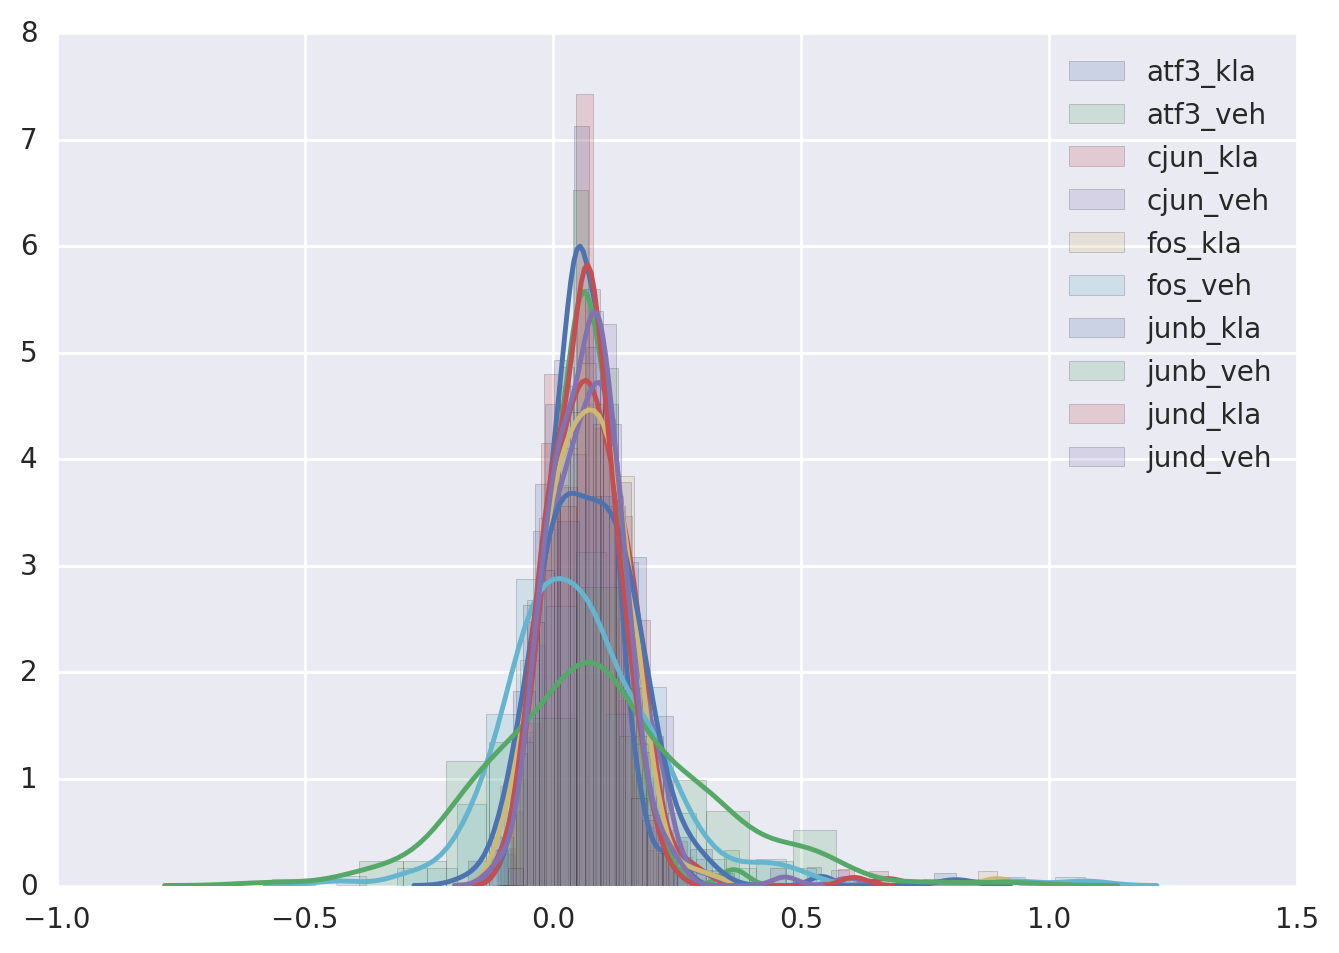

In [159]:
top_motifs_dict = {}
weight_threshold = 1.5
coefficients_randomBackground_frame = pd.DataFrame(factor_meanCoeff_randomBackground_dict)
coefficients_randomBackground_frame.index = standardized_motif_randomBackground_frame.columns.values
for col in coefficients_randomBackground_frame.columns.values:
    sns.distplot(coefficients_randomBackground_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_randomBackground_frame = coefficients_randomBackground_frame[[]]
for col in coefficients_randomBackground_frame:
    coefficients_zscore_randomBackground_frame[col] = scipy.stats.mstats.zscore(coefficients_randomBackground_frame[col].values)

coefficients_zscore_randomBackground_frame.index = coefficients_randomBackground_frame.index.values
coefficients_zscore_randomBackground_frame.columns = coefficients_randomBackground_frame.columns.values

### plot coefficents for vehicle


for monomer in ap1_members:
    for treatment in ['veh', 'kla']:

        data = coefficients_zscore_randomBackground_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs_dict[monomer + '_' + treatment] = data.index.values



In [337]:
# for monomers using motif counts and best motif score
strain = 'c57bl6'
# factor_coeff_dict_affinityCount = {}
# factor_auc_dict_affinityCount = {}
# factor_precision_dict_affinityCount = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        top_motifs = top_motifs_dict[monomer + '_' + treatment]
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                    affinity_features, labels, test_size = test_size)
                
                training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                     motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
                test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
                #  Train affinity classifier
                affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                affinity_classifier.fit(training_affinity_features, training_labels)
                
                # Train count classifier
                count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                count_classifier.fit(training_count_features, training_labels)
                
                # train combined classifier
                training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
                training_count_scores = count_classifier.decision_function(training_count_features)
                training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                                 'Count':training_count_scores})
                combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                combined_classifier.fit(training_combined_features, training_labels)

                # retrieve test probabilities
                test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
                test_count_scores = count_classifier.decision_function(test_count_features)
                test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                           'Count':test_count_scores})
                probas = combined_classifier.predict_proba(test_combined_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])

#             factor_auc_dict_affinityCount[monomer + '_' + treatment] = all_aucs
#             factor_precision_dict_affinityCount[monomer + '_' + treatment] = all_precisions
#             factor_coeff_dict_affinityCount[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.850652266047 5.72083316907e-06 precision: 0.841996366589 1.0140997708e-05 numTestPositives: 11013
cjun_veh roc: 0.868740165789 3.85340125179e-06 precision: 0.861053428911 2.31421170754e-06 numTestPositives: 6335
fos_veh roc: 0.919928221239 1.53972797857e-06 precision: 0.908829813789 4.43296583033e-06 numTestPositives: 994
junb_veh roc: 0.817754757495 0.000655478116618 precision: 0.818111484942 0.000573294801176 numTestPositives: 247
jund_veh roc: 0.823499089172 9.00948110298e-06 precision: 0.819636759975 9.06010788514e-06 numTestPositives: 9025
atf3_kla roc: 0.848808539147 9.79358976544e-07 precision: 0.835687242832 1.34926264062e-06 numTestPositives: 17327
cjun_kla roc: 0.845254281038 6.77774083996e-06 precision: 0.830893110403 1.16986563648e-05 numTestPositives: 8068
fos_kla roc: 0.838558659137 1.23479427553e-06 precision: 0.816835375476 3.97081101887e-06 numTestPositives: 10733
junb_kla roc: 0.875519642223 5.95528603405e-06 precision: 0.864310730249 9.35079700035e-06

## Test Different Thresholds

In [ ]:
numIterations = 5
factor_auc_dict = {}
factor_precision_dict = {}
factor_numMotifs_dict = {}
for monomer in ap1_members:
    for treatment in ['veh', 'kla']:
        for weight_threshold in np.arange(0,2.1,0.1):
            data = coefficients_zscore_randomBackground_frame
            data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                        (data[monomer + '_' + treatment] < -1 * weight_threshold)
                        ]
            top_motifs = data.index.values
            target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
            background_indices = motif_score_background_frame[
                motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
            # select subset of background indices to use
            shuffle(background_indices)
            background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

            target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
            background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]

            # merge target and background features together 
            affinity_features = pd.concat([target_affinity_features, background_affinity_features])
            affinity_features = affinity_features[top_motifs]
            labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                               index = affinity_features.index.values)

            if np.sum(labels) >= 100:
                all_aucs = []
                all_coefficients = []
                all_precisions = []
                all_intercepts = []
                for i in range(numIterations):  

                    # split data into training and test sets
                    training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                        affinity_features, labels, test_size = test_size)

                    training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                         motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
                    test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                                     motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
                    #  Train affinity classifier
                    affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    affinity_classifier.fit(training_affinity_features, training_labels)

                    # Train count classifier
                    count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    count_classifier.fit(training_count_features, training_labels)

                    # train combined classifier
                    training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
                    training_count_scores = count_classifier.decision_function(training_count_features)
                    training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                                     'Count':training_count_scores})
                    combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    combined_classifier.fit(training_combined_features, training_labels)

                    # retrieve test probabilities
                    test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
                    test_count_scores = count_classifier.decision_function(test_count_features)
                    test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                               'Count':test_count_scores})
                    probas = combined_classifier.predict_proba(test_combined_features)

                    # score predictions
                    current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                    current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                    all_aucs.append(current_roc_auc)
                    all_precisions.append(current_precision)

                    # score all sequences
                    current_coefficients = lr_classifier.coef_.flatten()
                    all_coefficients.append(current_coefficients)
                    all_intercepts.append(lr_classifier.intercept_[0])
                if not monomer + '_' + treatment in factor_auc_dict:
                    factor_auc_dict[monomer+ '_' + treatment] = []
                    factor_precision_dict[monomer+ '_' + treatment] = []
                    factor_numMotifs_dict[monomer+ '_' + treatment] = []
                factor_auc_dict[monomer + '_' + treatment].append(np.mean(all_aucs))
                factor_precision_dict[monomer + '_' + treatment].append(np.mean(all_precisions))
                factor_numMotifs_dict[monomer + '_' + treatment].append(len(top_motifs))
                print(monomer + '_' + treatment,
                      'roc:', np.mean(all_aucs), 
                      'precision:', np.mean(all_precisions),  
                      'numMotifs:', len(top_motifs),
                      'threshold:', weight_threshold
                      
                     )

In [203]:
threshold_numMotifs_frame = pd.DataFrame(factor_numMotifs_dict, index = np.arange(0,2.1,0.1))
auc_frame = pd.DataFrame(factor_auc_dict, index = np.arange(0,2.1,0.1))
precision_frame = pd.DataFrame(factor_precision_dict, index = np.arange(0,2.1,0.1))




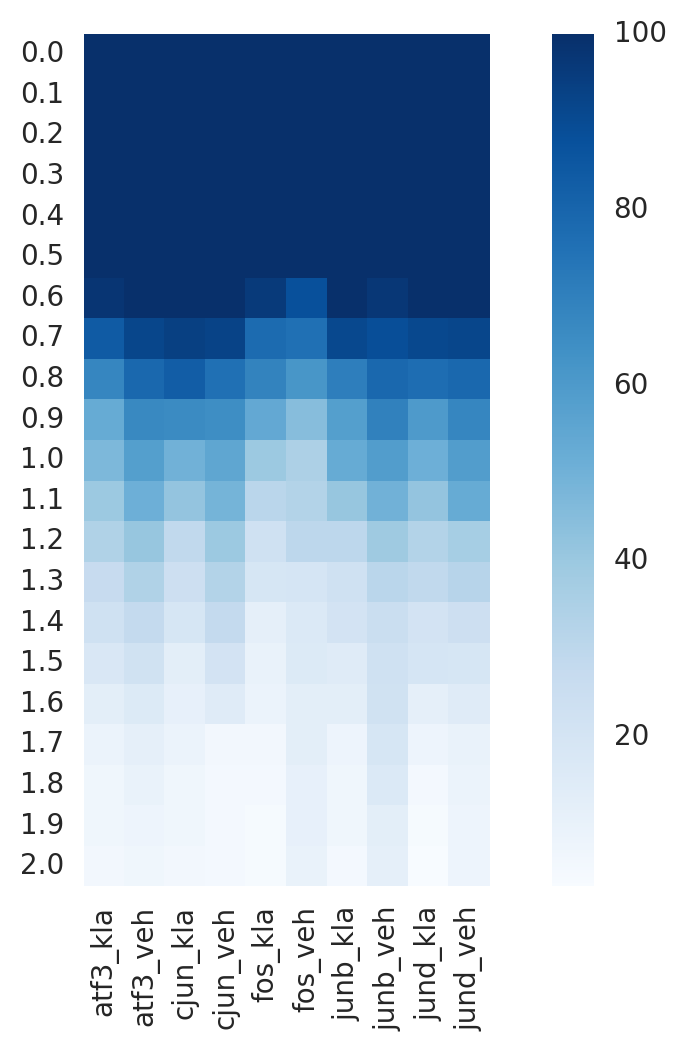

In [209]:
cg = sns.heatmap(threshold_numMotifs_frame, 
                 square=True, 
                 cmap='Blues',
                 vmax=100,
                 vmin=3
                )
plt.setp(cg.xaxis.get_majorticklabels(), fontsize=10, rotation=90);

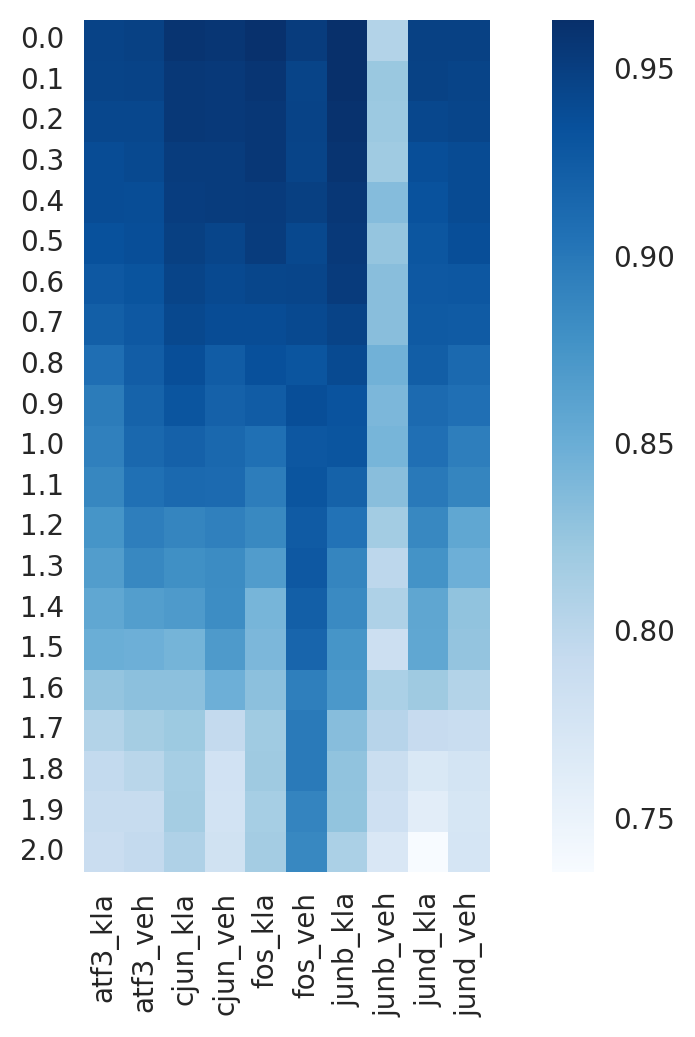

In [204]:
cg = sns.heatmap(auc_frame, 
                 square=True, 
                 cmap='Blues',
                )
plt.setp(cg.xaxis.get_majorticklabels(), fontsize=10, rotation=90);

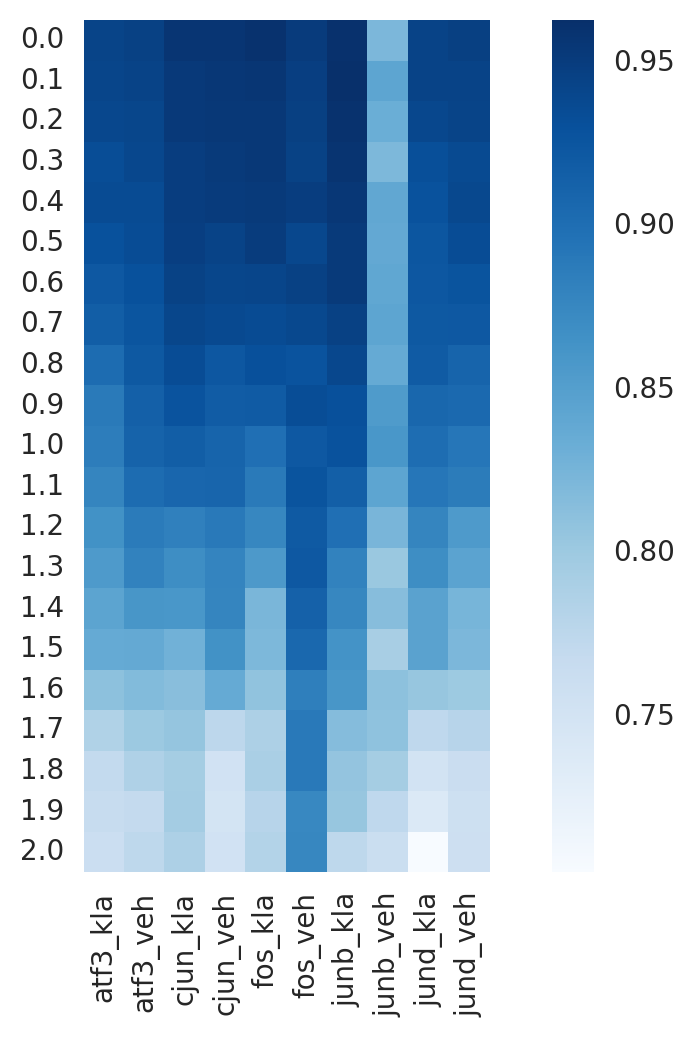

In [205]:
cg = sns.heatmap(precision_frame, 
                 square=True, 
                 cmap='Blues',
                )
plt.setp(cg.xaxis.get_majorticklabels(), fontsize=10, rotation=90);

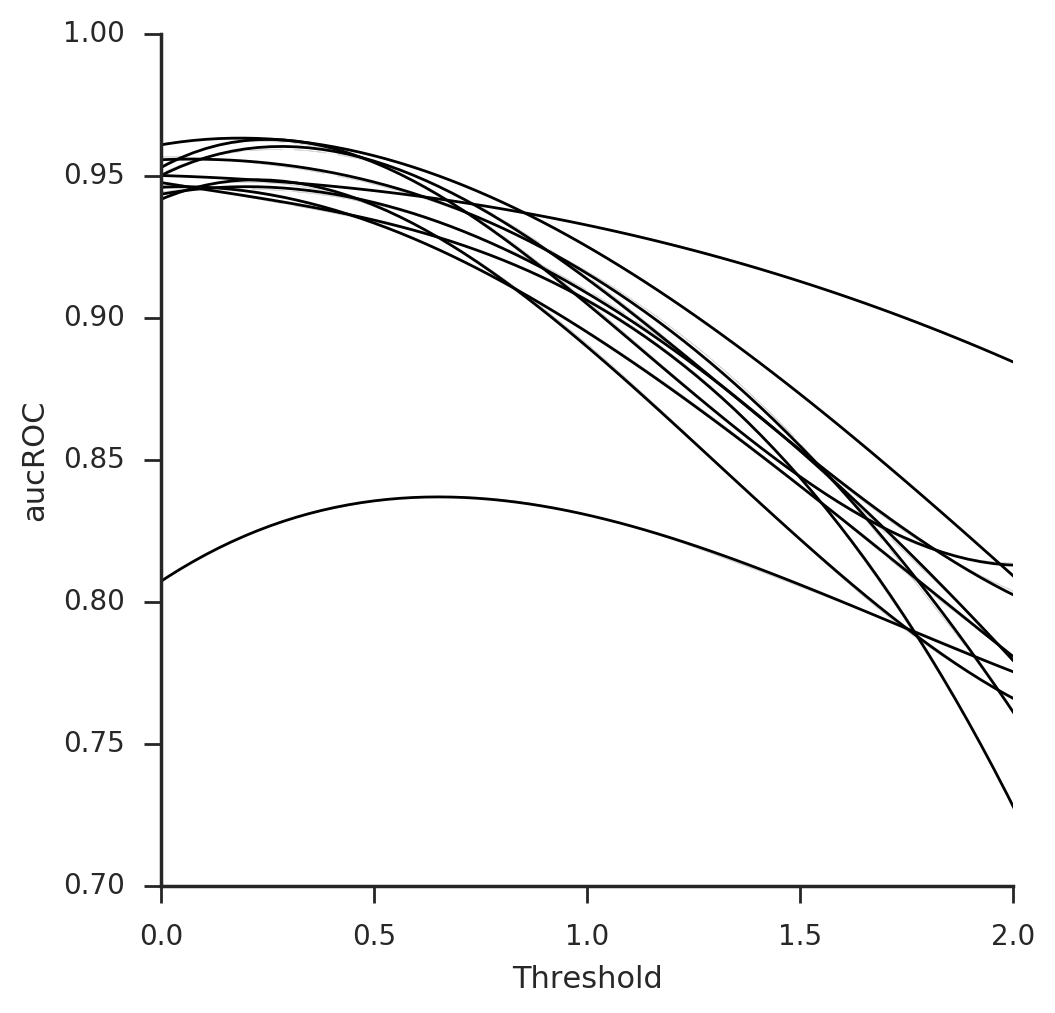

In [331]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        performance = factor_auc_dict[key]
        sns.regplot(x=np.arange(0,2.1,0.1), 
                    y=np.array(performance),
                    order =3,
                    label=key,
                    ci=0,
                    color='black',
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'},
                    line_kws = {'linewidth':1}
                   )
    sns.despine()    
    plt.xlim(0,2)
    plt.ylim(0.7,1)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))


    plt.xlabel('Threshold')
    plt.ylabel('aucROC')

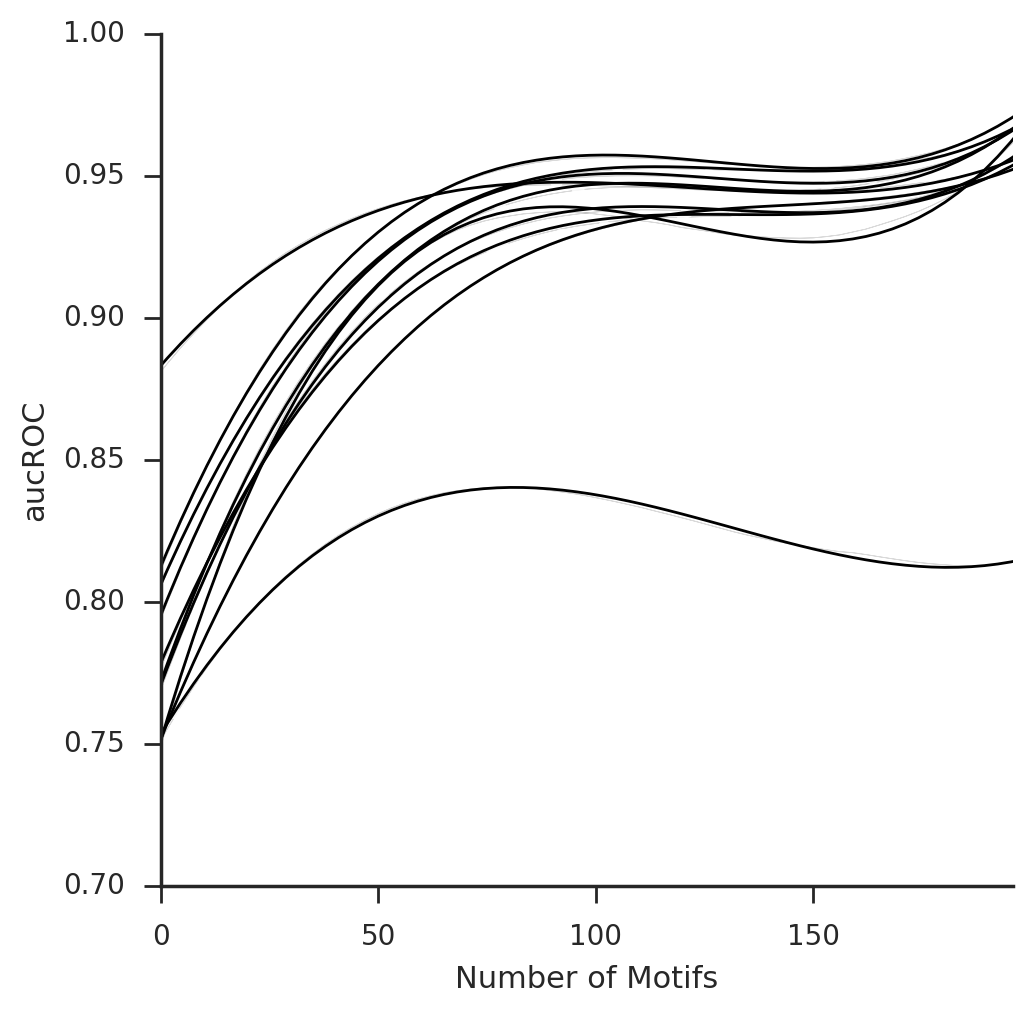

In [305]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        numMotifs = factor_numMotifs_dict[key]
        performance = factor_auc_dict[key]
        sns.regplot(x=np.array(numMotifs), 
                    y=np.array(performance),
                    order = 3,
                    label=key,
                    ci=0,
                    color='black',
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'},
                    line_kws = {'linewidth':1}
                   )
    sns.despine()    
    plt.xlim(0,196)
    plt.ylim(0.7,1)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))


    plt.xlabel('Number of Motifs')
    plt.ylabel('aucROC')

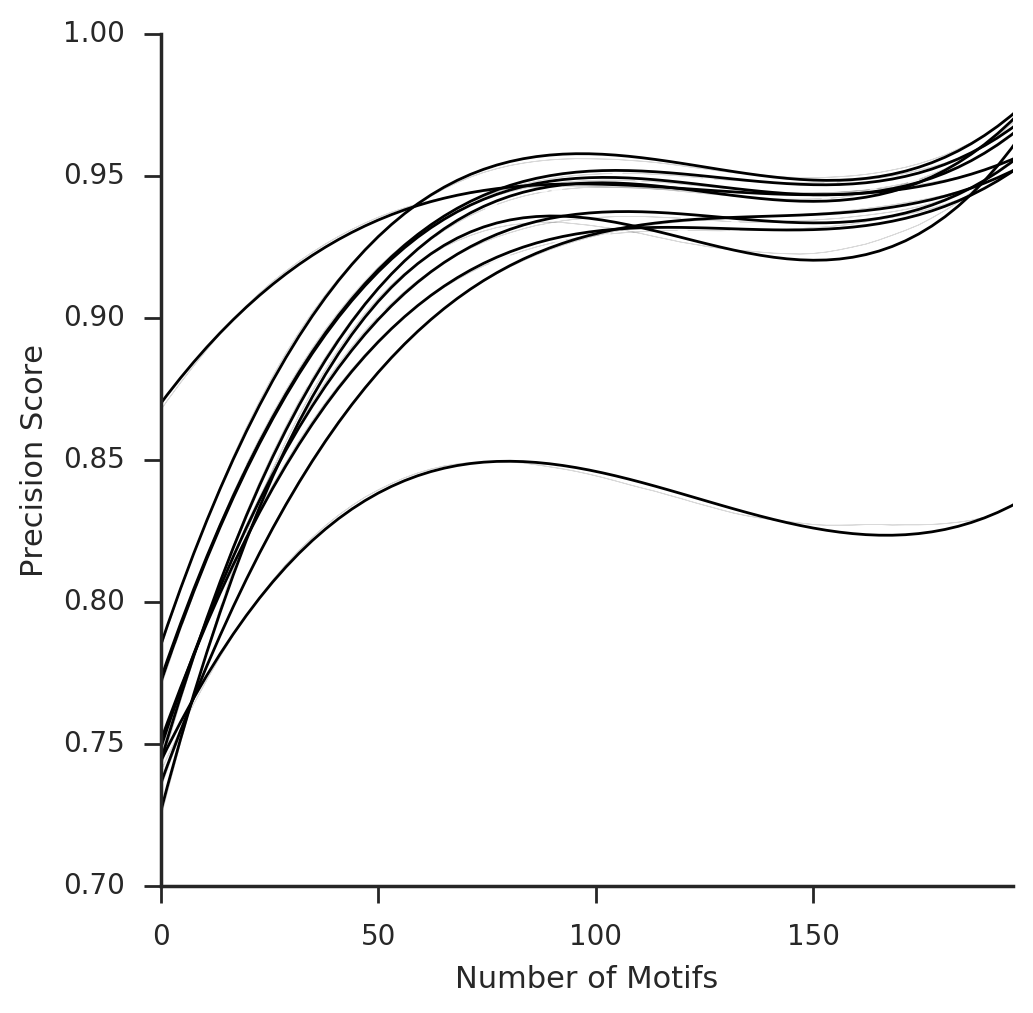

In [296]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        numMotifs = factor_numMotifs_dict[key]
        performance = factor_precision_dict[key]
        sns.regplot(x=np.array(numMotifs), 
                    y=np.array(performance),
                    order = 3,
                    label=key,
                    ci=0,
                    color='black',
                    line_kws = {'linewidth':1},
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'}
                   )
    sns.despine()    
    plt.xlim(0,196)
    plt.ylim(0.7,1)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                
    plt.xlabel('Number of Motifs')
    plt.ylabel('Precision Score')

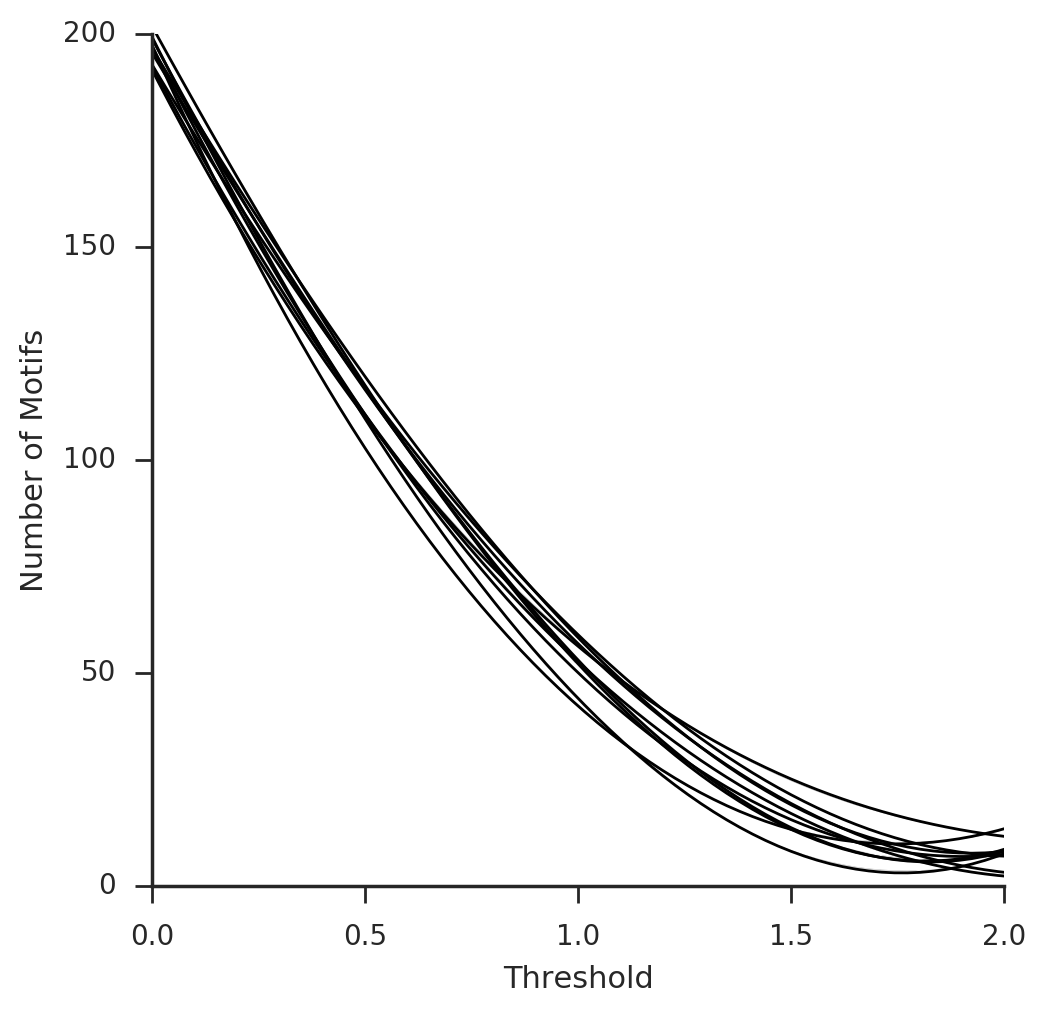

In [297]:
with sns.axes_style('ticks'):
    for key in sorted(factor_numMotifs_dict):
        numMotifs = factor_numMotifs_dict[key]
        sns.regplot(x=np.arange(0,2.1,0.1), 
                    y=np.array(numMotifs),
                    order =3,
                    label=key,
                    ci=0,
                    color='black',
                    line_kws = {'linewidth':1},
                    scatter_kws={'edgecolor':'None',
                                 'c':'white'}
                    
                   )
    plt.ylabel('Number of Motifs')
    plt.xlabel('Threshold')
    sns.despine()    
    plt.xlim(0,2)
    plt.ylim(0,200)
    
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))


    

## Comparioson of Random Background Coefficients Vs Open Chromatin background Coefficients

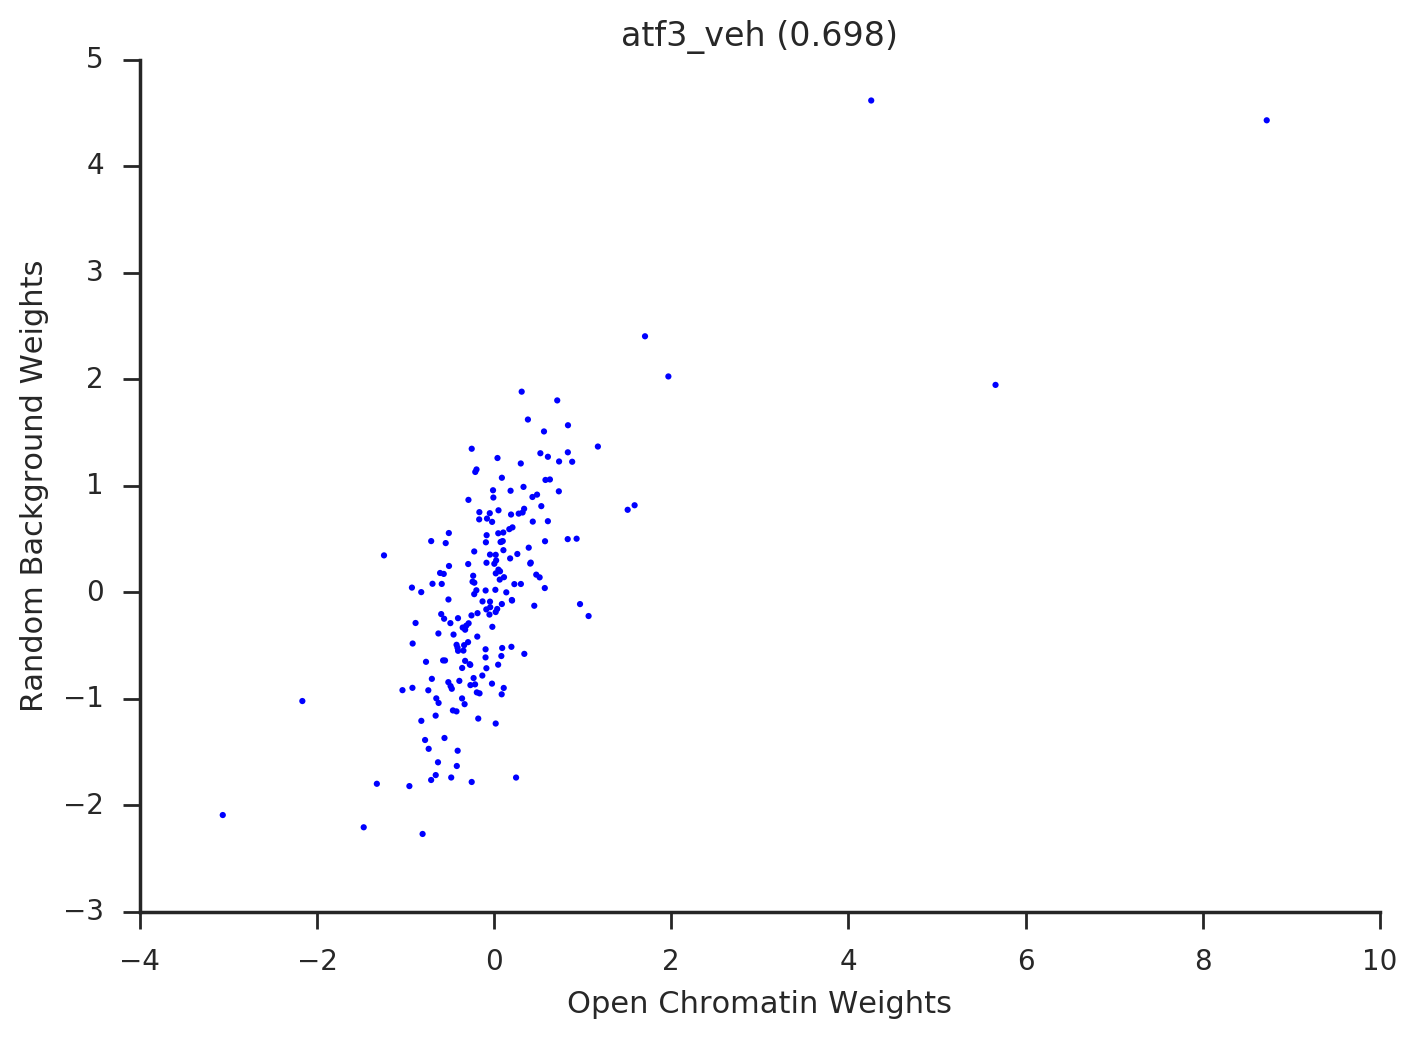

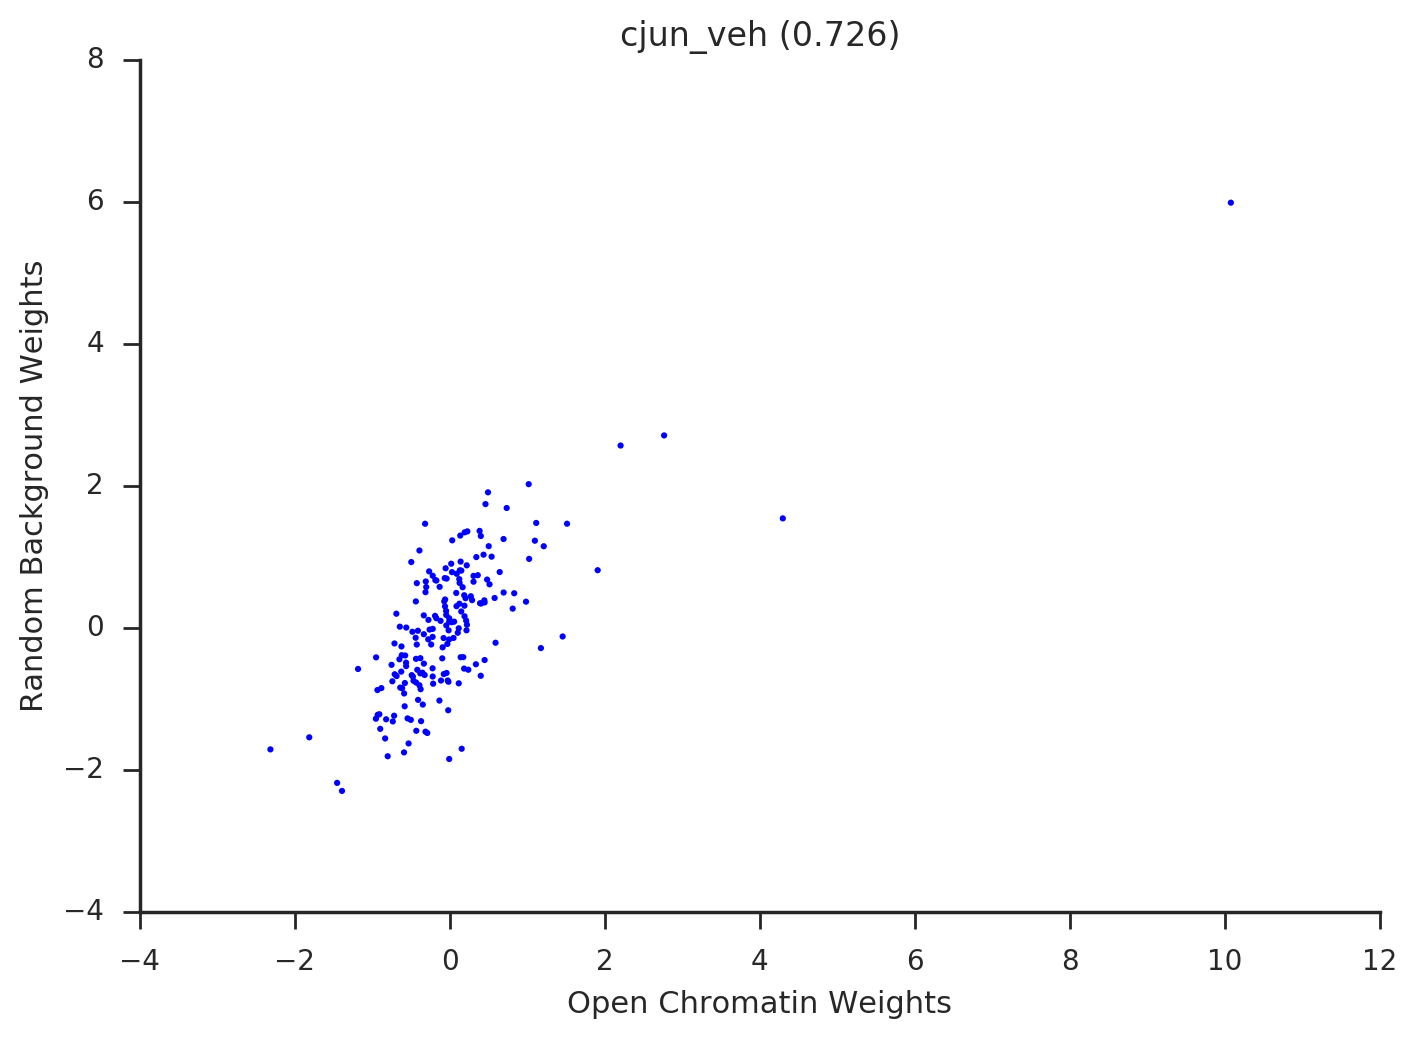

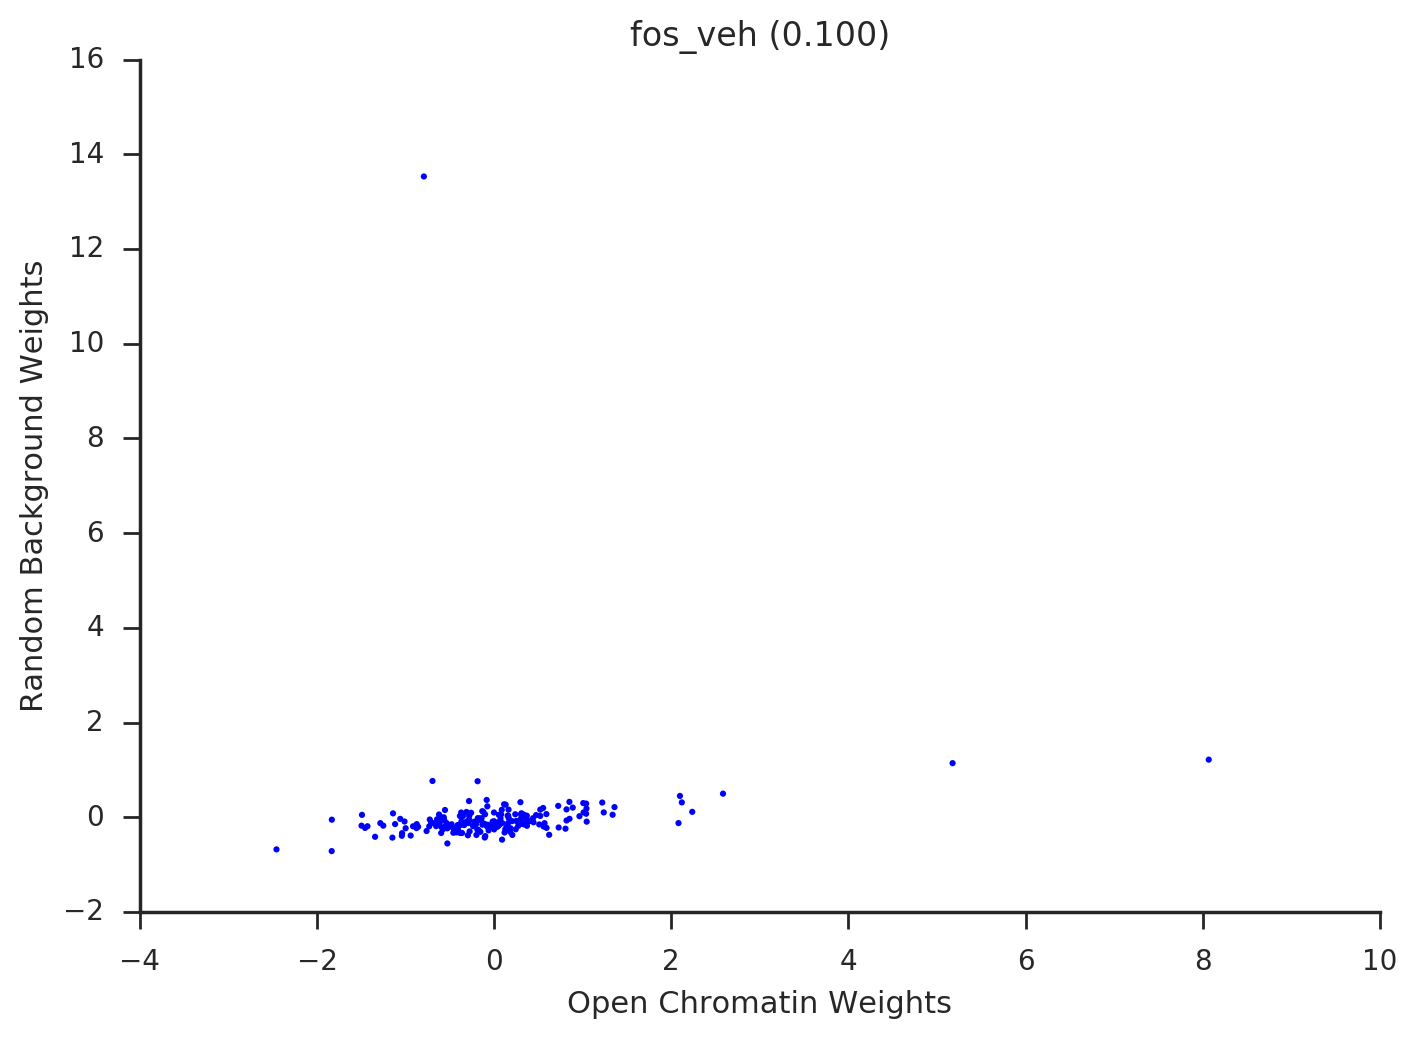

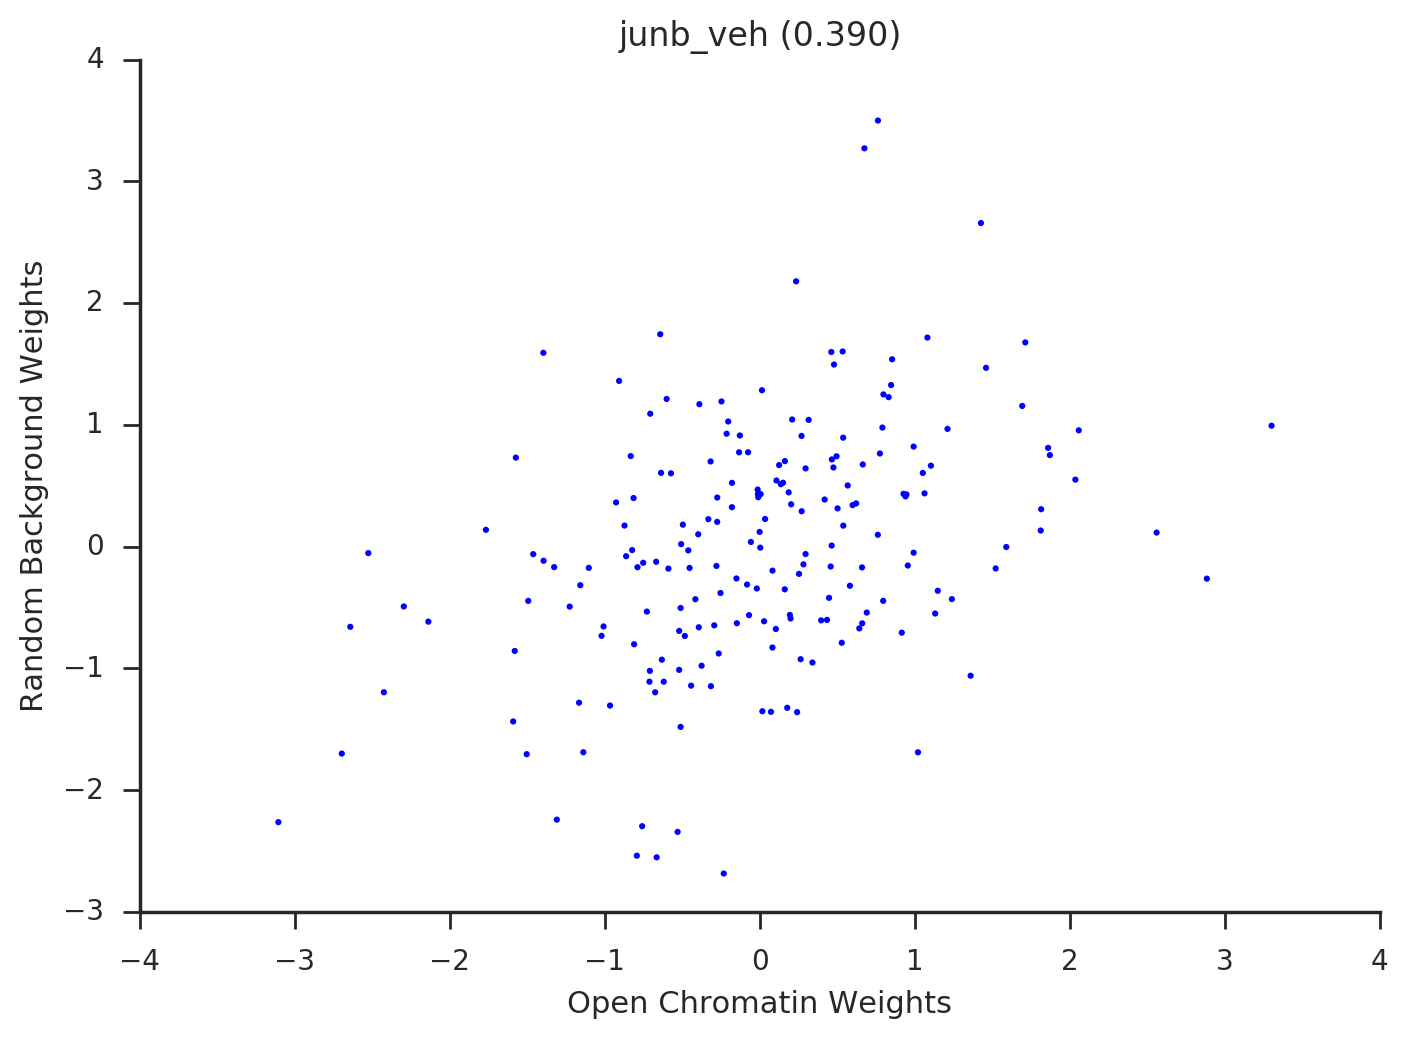

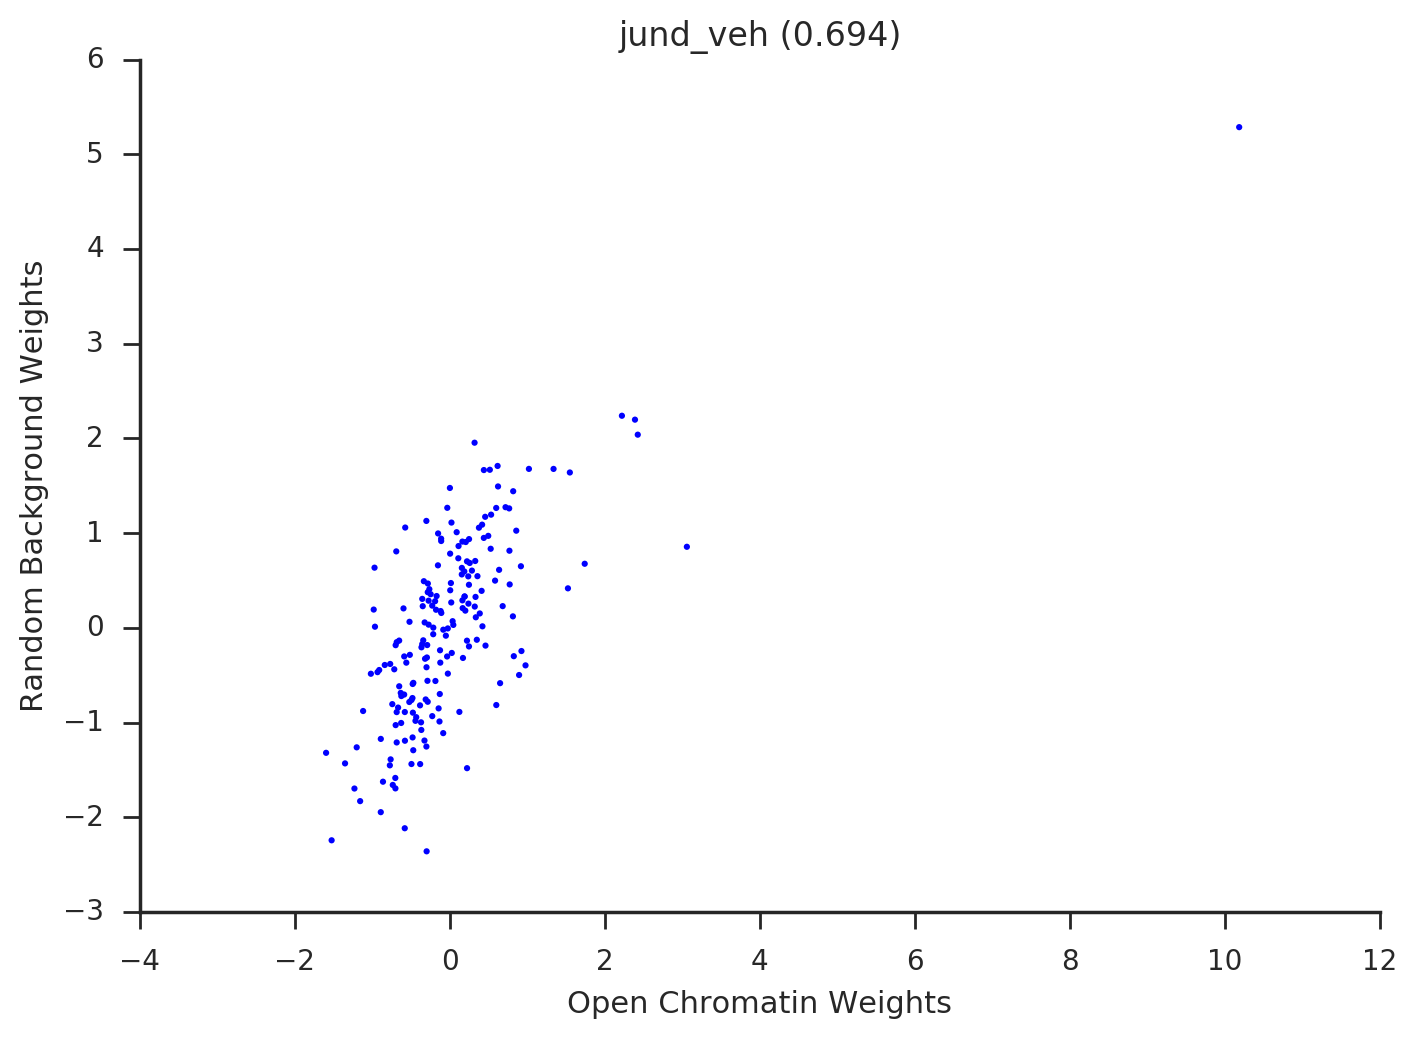

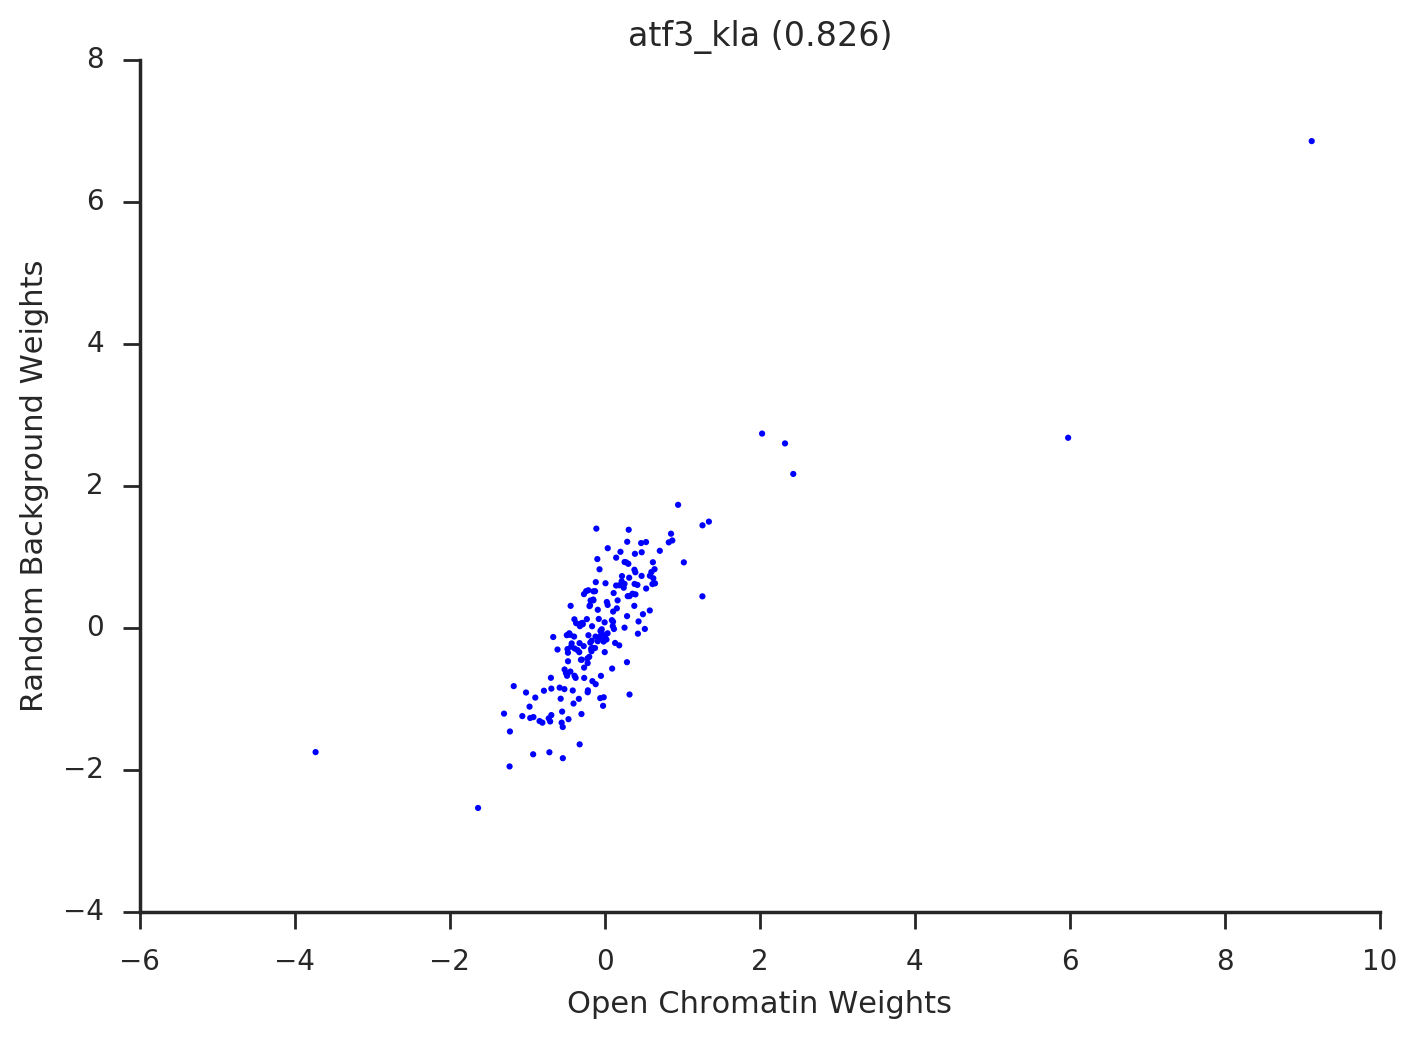

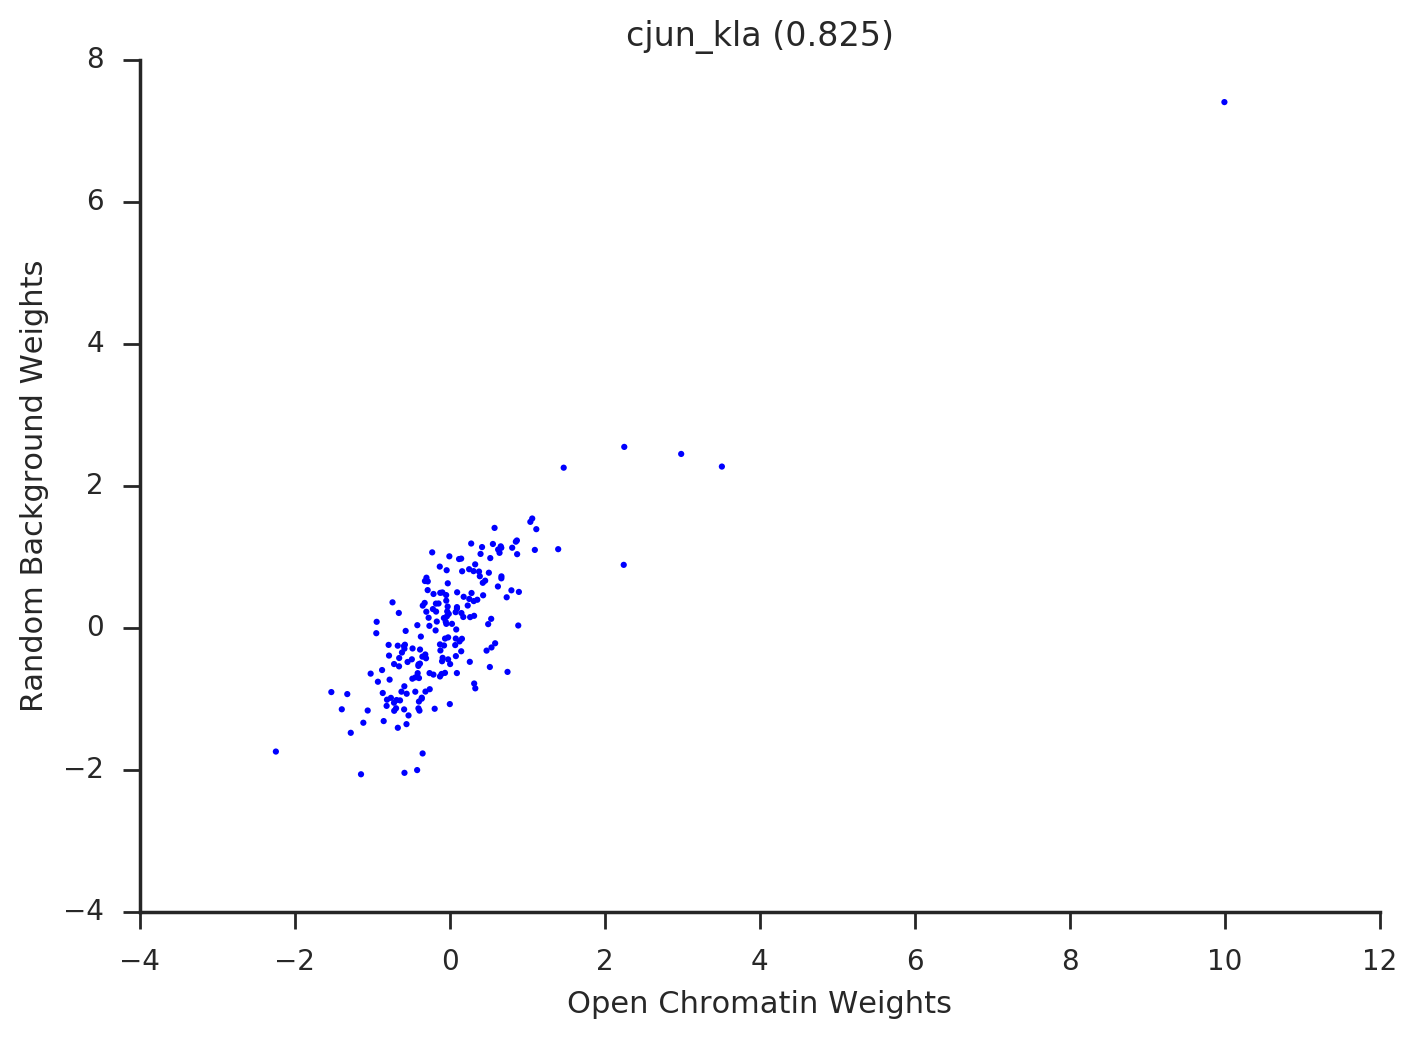

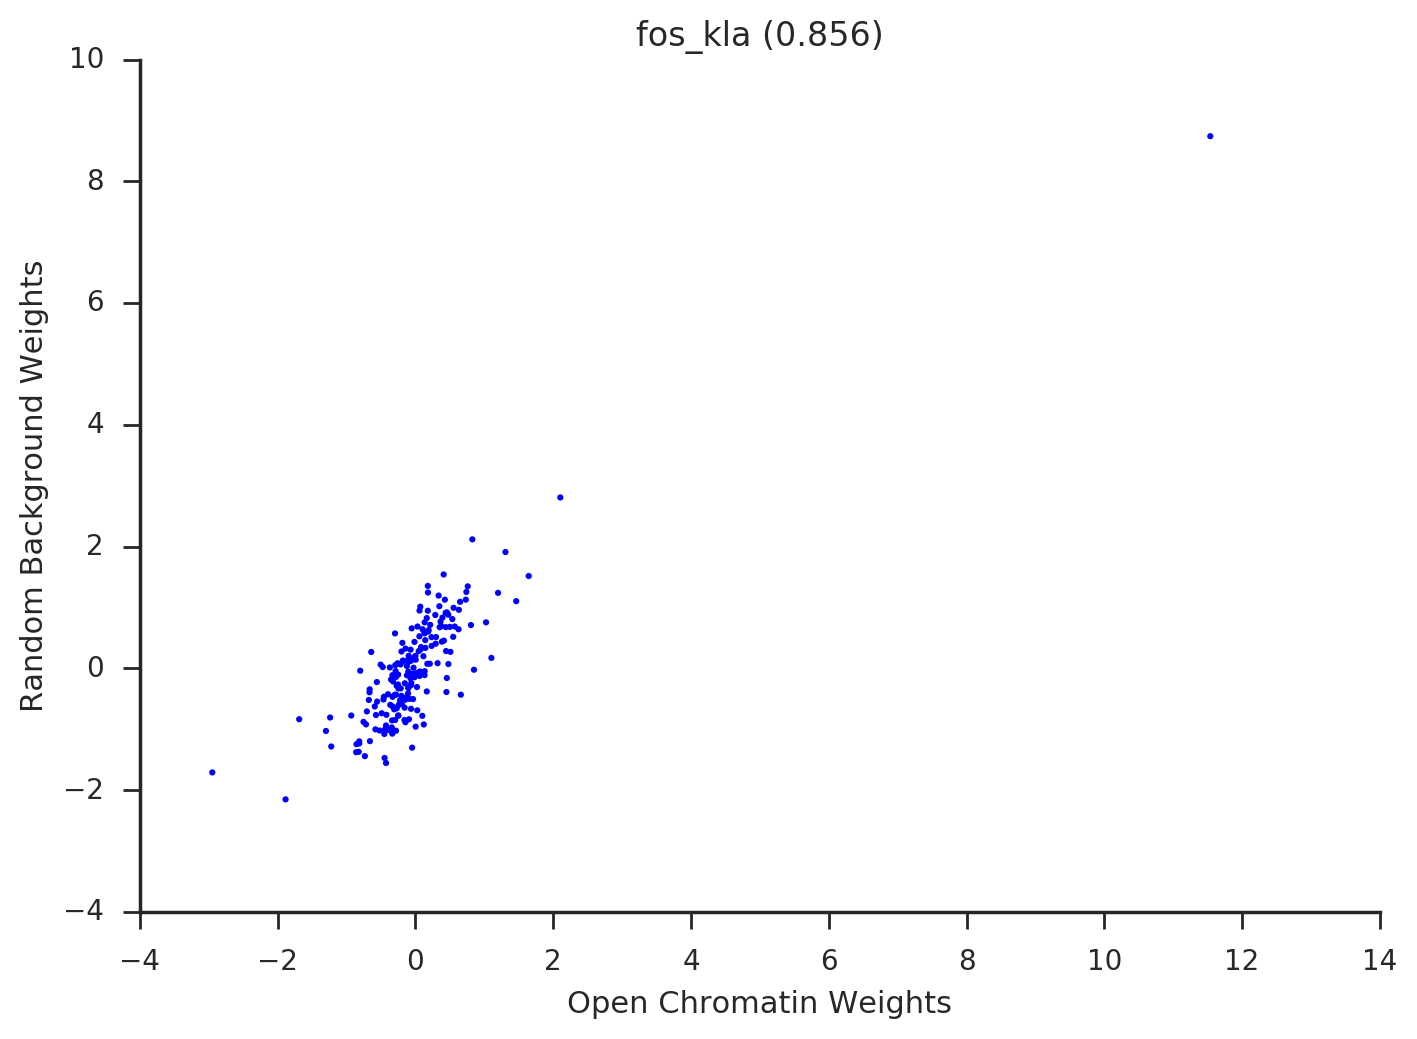

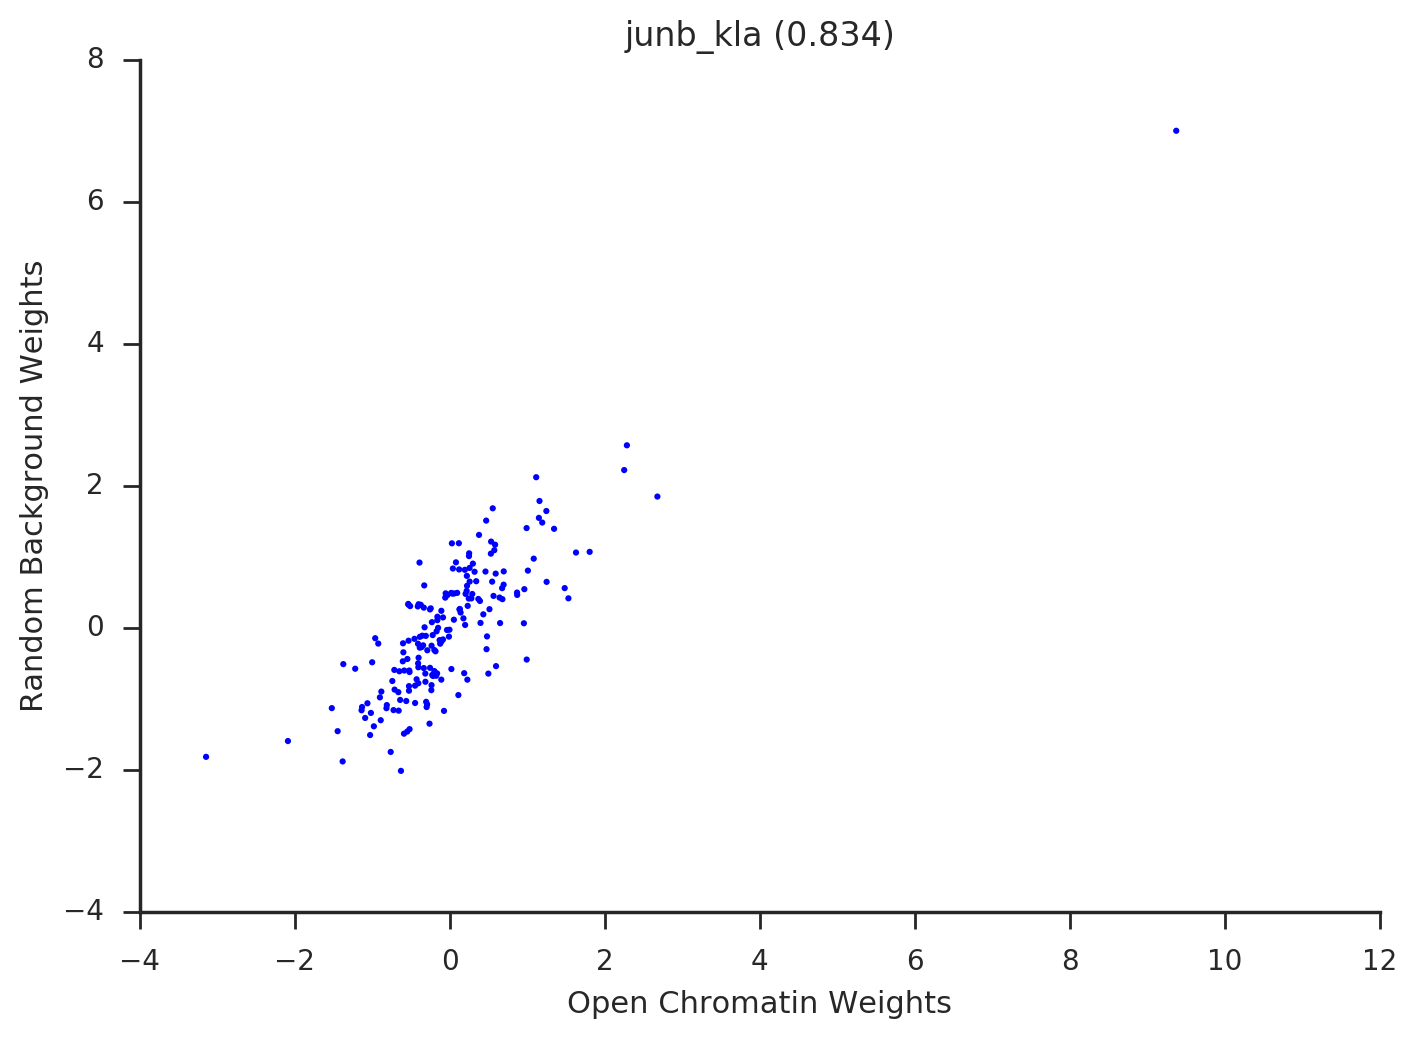

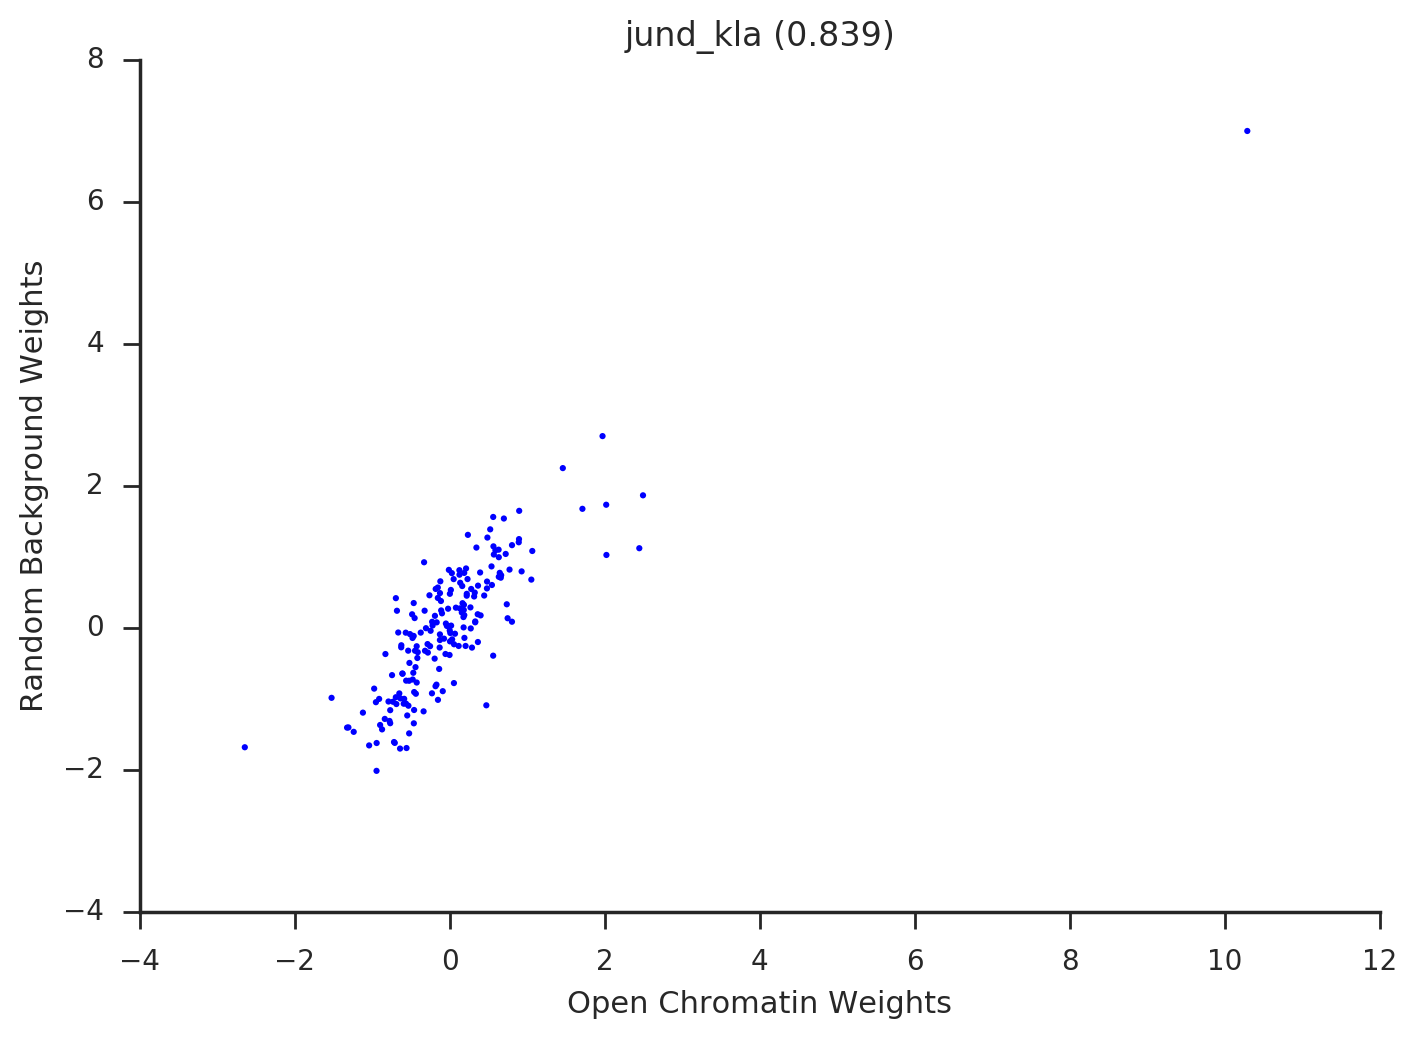

In [71]:
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        chrom_weights = coefficients_zscore_frame[monomer + '_' + treatment]
        randomBackground_weights = coefficients_zscore_randomBackground_frame[monomer + '_' + treatment]

        pearson, pval = scipy.stats.pearsonr(chrom_weights, randomBackground_weights)
        with sns.axes_style('ticks'):
#             data = pd.DataFrame({'Open Chromatin': chrom_weights, 
#                  'Random Background': randomBackground_weights})
#             sns.residplot(data = data, 
#                 x = 'Open Chromatin',
#                 y= 'Random Background')
            plt.scatter(chrom_weights, randomBackground_weights, marker = '.', edgecolors='None')
            plt.xlabel('Open Chromatin Weights')
            plt.ylabel('Random Background Weights')
            plt.title(monomer + '_' + treatment + ' (' + str(pearson)[:5] + ')')
            sns.despine()
            plt.show()
        



## Correlation with Peak Scores

array([ 33.,  48.,  46., ...,   0.,   0.,   0.])

atf3 veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.560518512559 (44050, 196) 44050


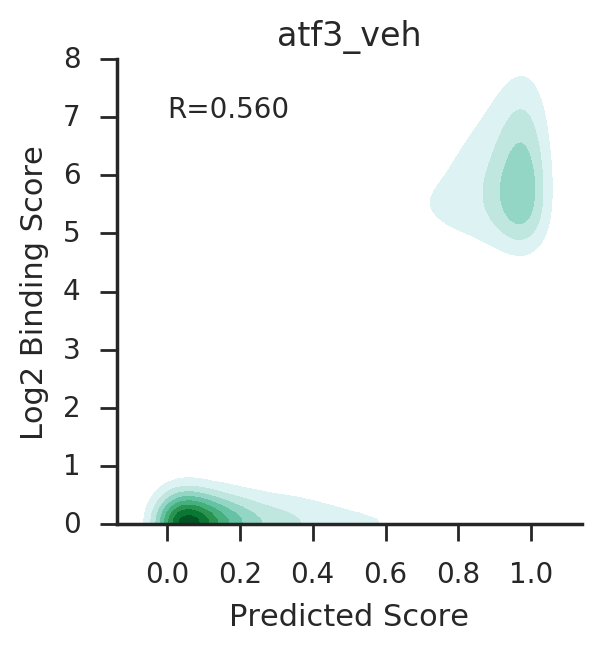

cjun veh
0.622636168497 (25340, 196) 25340


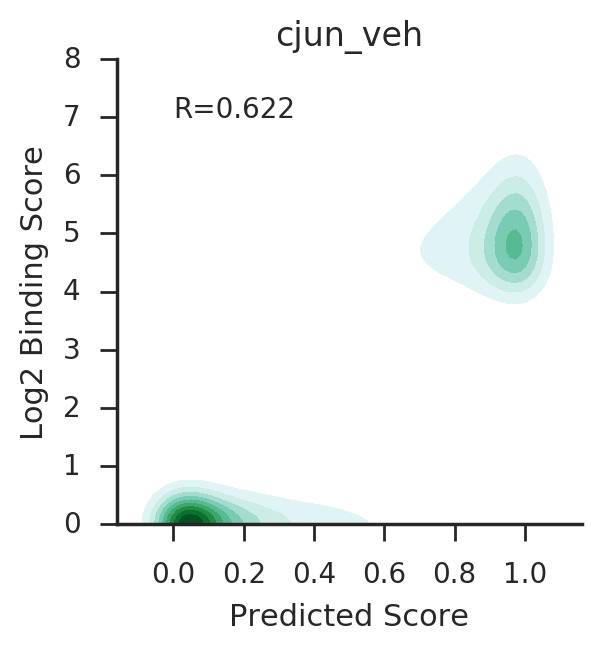

fos veh
0.648770536153 (3976, 196) 3976


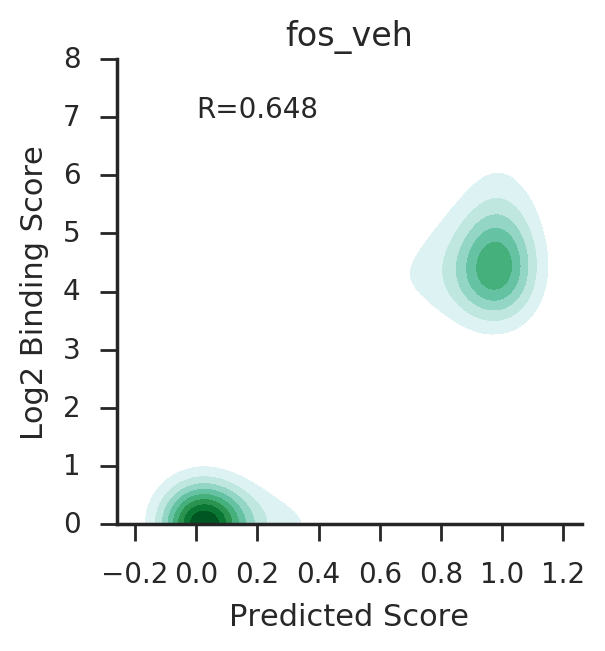

junb veh
0.623458672447 (986, 196) 986


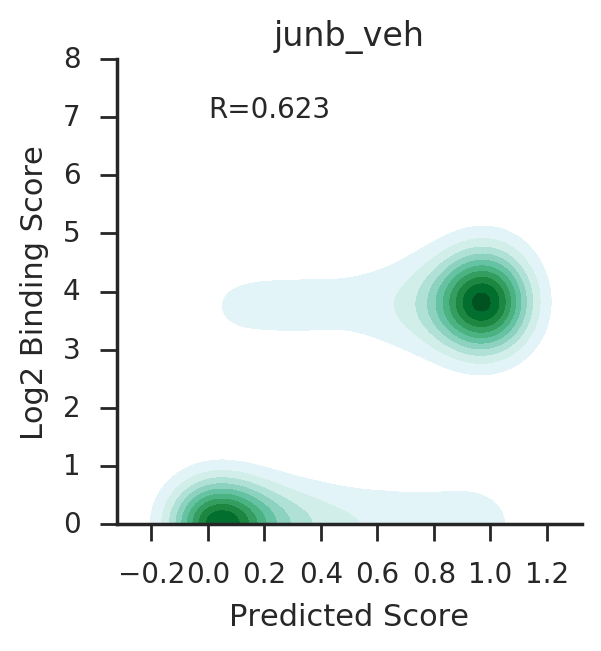

jund veh
0.592292405181 (36098, 196) 36098


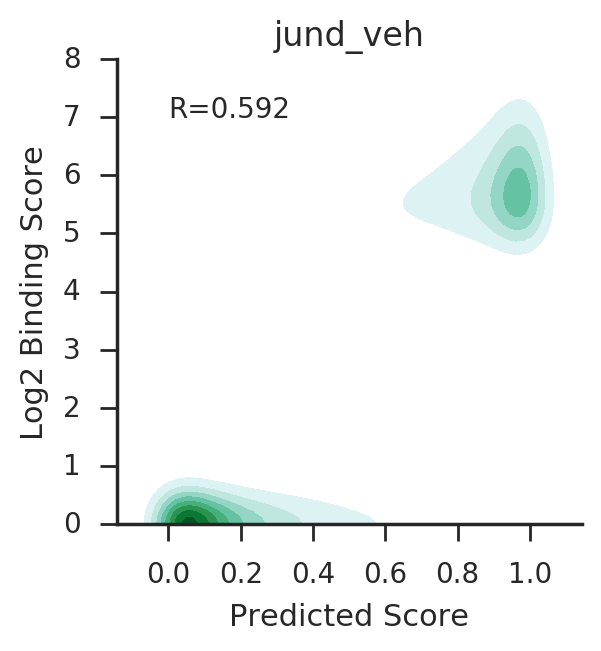

atf3 kla
0.596017313989 (69308, 196) 69308


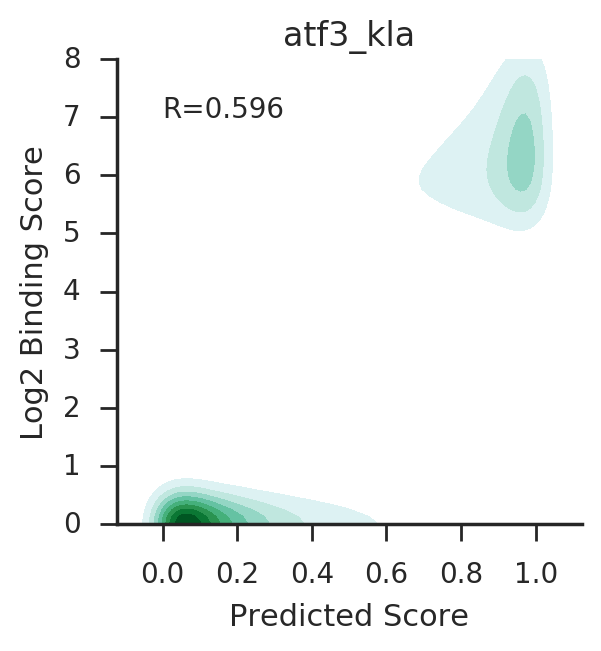

cjun kla
0.634776710829 (32270, 196) 32270


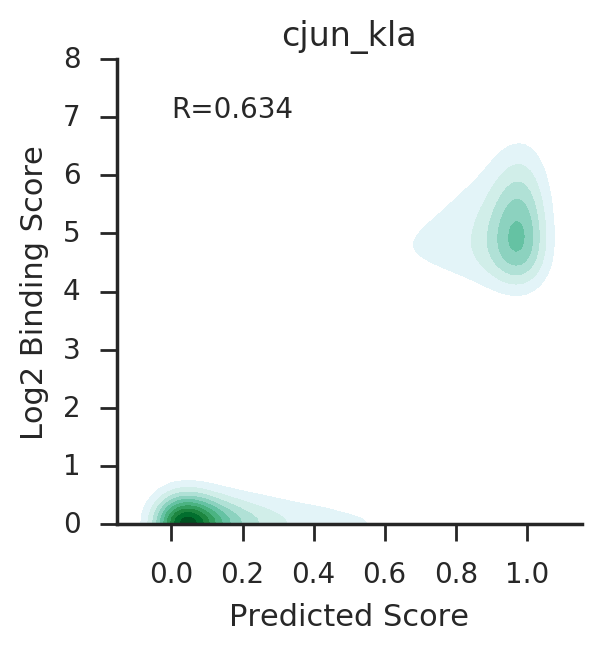

fos kla
0.629278184138 (42930, 196) 42930


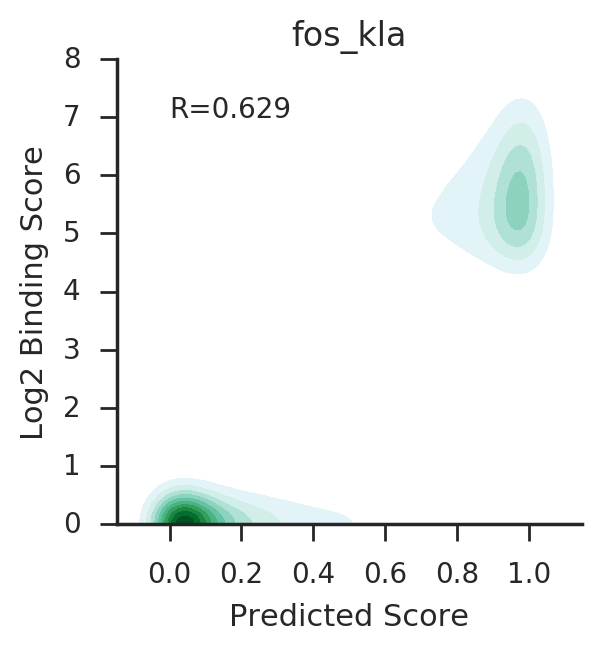

junb kla
0.622957786237 (28160, 196) 28160


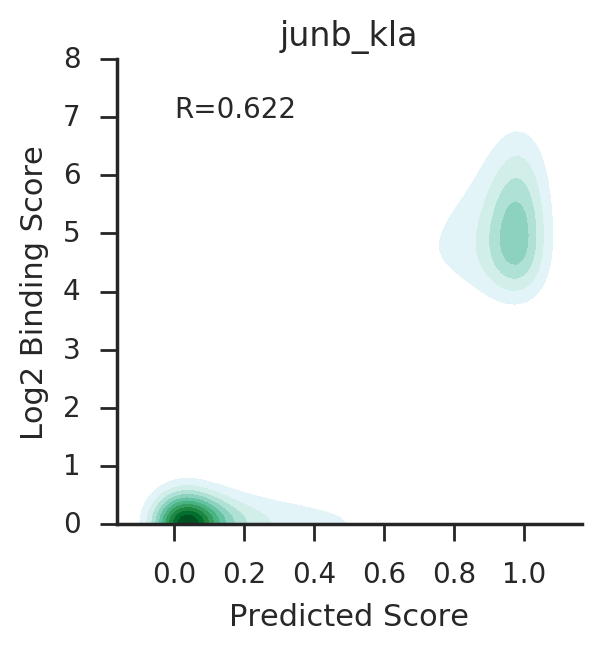

jund kla
0.62339241958 (59928, 196) 59928


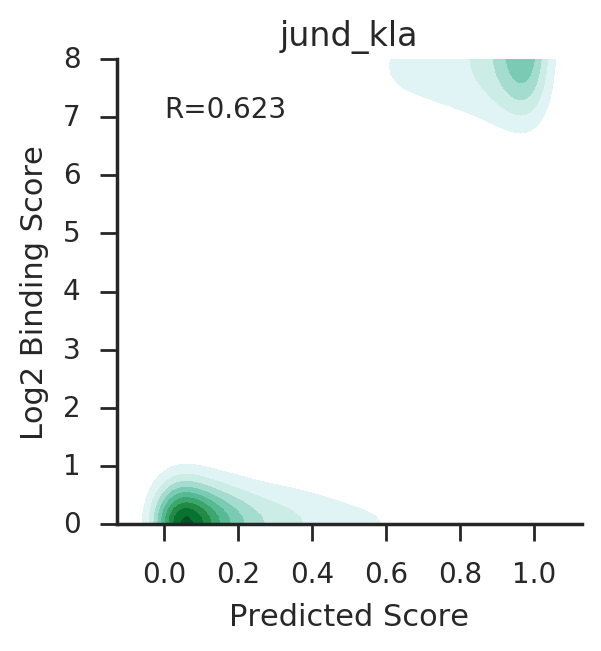

In [325]:
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print(monomer, treatment)
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) >= 100:

            # calculate probabilities using averaged weights
            weights = factor_meanCoeff_randomBackground_dict[monomer + '_' + treatment]
            intercept = factor_meanIntercept_randomBackground_dict[monomer + '_' + treatment]
            scores = np.dot(features, weights) + intercept
            probs = np.array([signmoid(x) for x in scores])

            # get real binding scores
            binding_scores = summary_frame[summary_frame.index.isin(labels.index.values)][strain + '_' + monomer + '_' + treatment]
            binding_scores = np.concatenate([binding_scores, np.array([0.0] * len(background_indices))])
            pearson, pval = scipy.stats.pearsonr(scores, binding_scores)
            print(pearson, features.shape, len(binding_scores))
            with sns.axes_style('ticks'):
                fig = plt.figure(figsize=(3,3))
#                 plt.scatter(probs, np.log2(binding_scores + 1), 
#                             marker = '.',
#                             edgecolor='None',
#                             s=1)
                sns.kdeplot(probs, np.log2(binding_scores + 1), 
                            shade=True,
                            shade_lowest = False)
                
                plt.xlabel('Predicted Score')
                plt.ylabel('Log2 Binding Score')
                plt.annotate('R='+str(pearson)[:5], xy = (0,7), size=10)
                sns.despine()
#                 plt.xlim(-0.1,1.1)
                plt.ylim(0,8)
                plt.title(monomer + '_' + treatment)
                ax = plt.gca()
                x0,x1 = ax.get_xlim()
                y0,y1 = ax.get_ylim()
                ax.set_aspect(abs(x1-x0)/abs(y1-y0))
                plt.show()

## Run gkmSVM against Random Genomic Background

In [187]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi
! rm ./gkmsvm_files/*

In [188]:
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [189]:
### for all peaks in vehicle using gapped k-mers on randomBackground data
### write script
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '_randomBackground.sh', 'w')
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_randomBackground_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_randomBackground_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_randomBackground_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_randomBackground'
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')
                

    script_file.close()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh
cjun_veh
fos_veh
junb_veh
jund_veh
atf3_kla
cjun_kla
fos_kla
junb_kla
jund_kla


In [ ]:
%%bash
chmod a+x ./gkmsvm_veh_randomBackground.sh 
./gkmsvm_veh_randomBackground.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_randomBackground.sh 
./gkmsvm_kla_randomBackground.sh

In [195]:
### for all peaks in vehicle using gapped k-mers on randomBackground data
### read performance
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration) + '_randomBackground'
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )



atf3_veh
atf3_veh roc: 0.978664113795 precision: 0.977268969262 numTestPositives: 11013
cjun_veh
cjun_veh roc: 0.978179674812 precision: 0.976441174552 numTestPositives: 6335
fos_veh
fos_veh roc: 0.958472363355 precision: 0.959144752866 numTestPositives: 994
junb_veh
junb_veh roc: 0.795931747775 precision: 0.813260721544 numTestPositives: 247
jund_veh
jund_veh roc: 0.977921927548 precision: 0.976773221558 numTestPositives: 9025
atf3_kla
atf3_kla roc: 0.977683990726 precision: 0.975901057135 numTestPositives: 17327
cjun_kla
cjun_kla roc: 0.979348889054 precision: 0.97785240498 numTestPositives: 8068
fos_kla
fos_kla roc: 0.979674771687 precision: 0.977784267093 numTestPositives: 10733
junb_kla
junb_kla roc: 0.975658586486 precision: 0.974483041223 numTestPositives: 7040
jund_kla
jund_kla roc: 0.977665990984 precision: 0.976010959346 numTestPositives: 14982


## Visualize Performance

### ROC

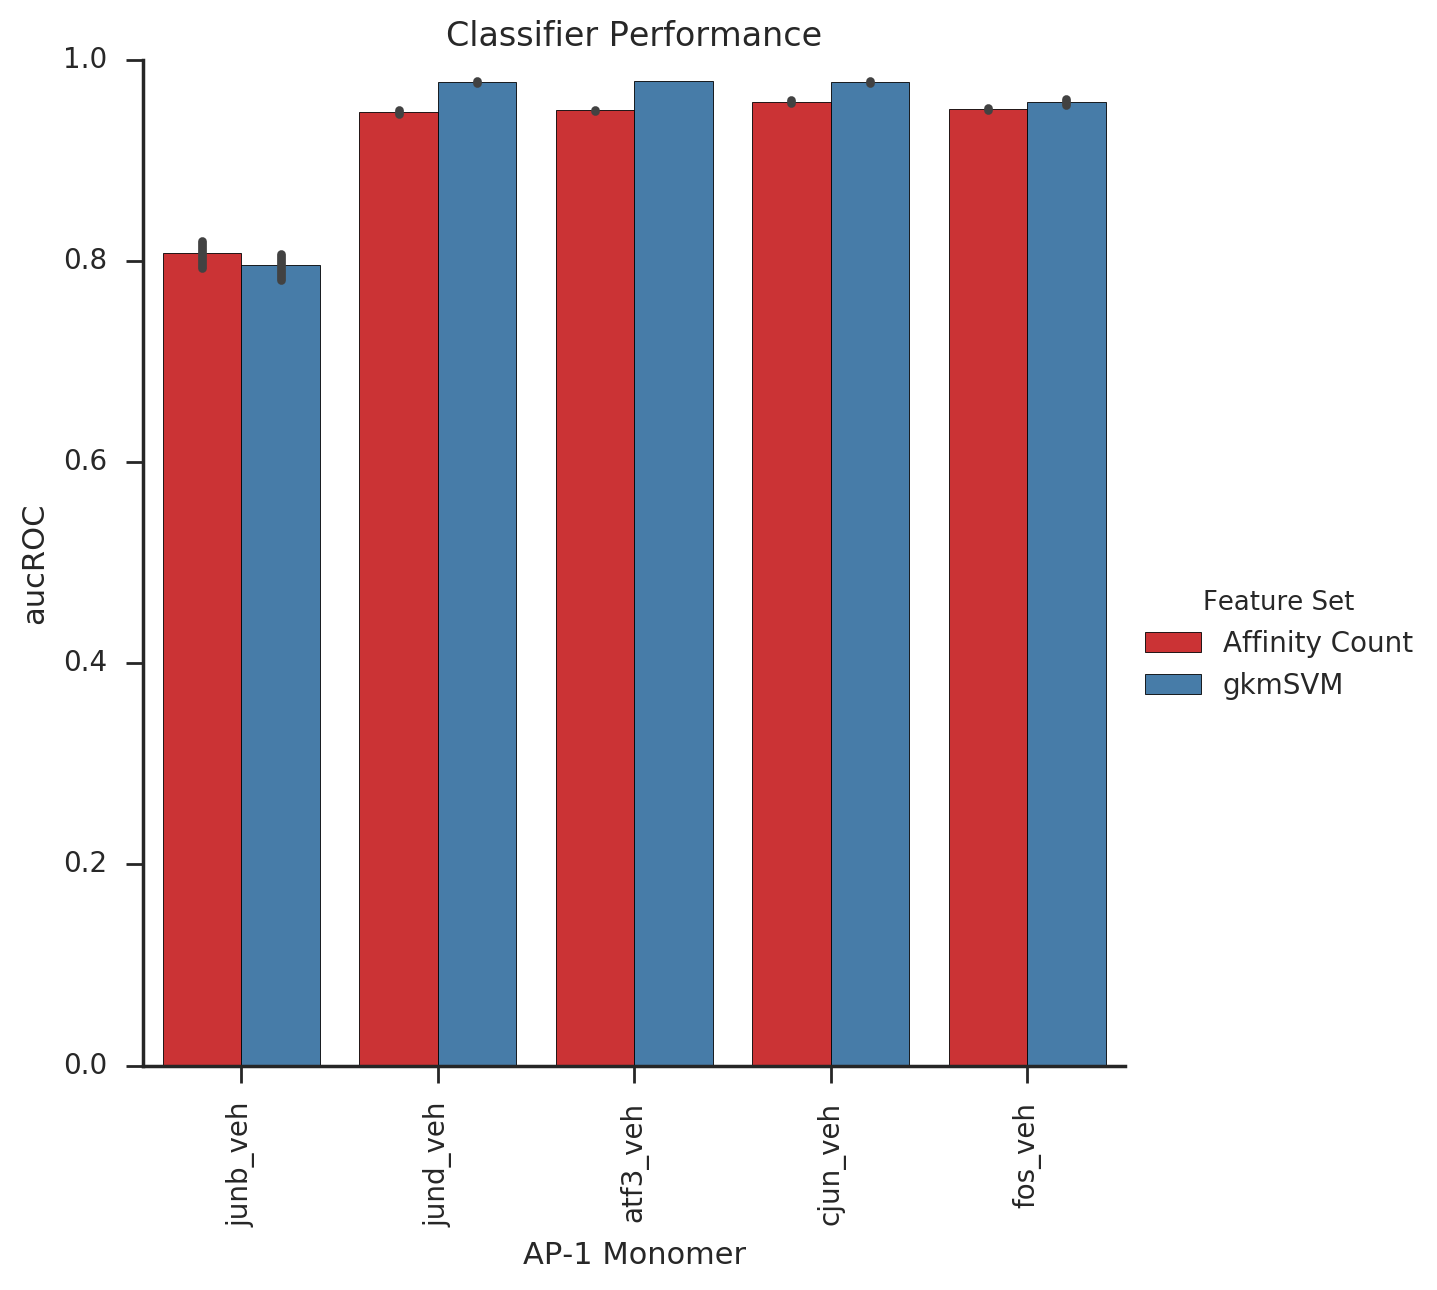

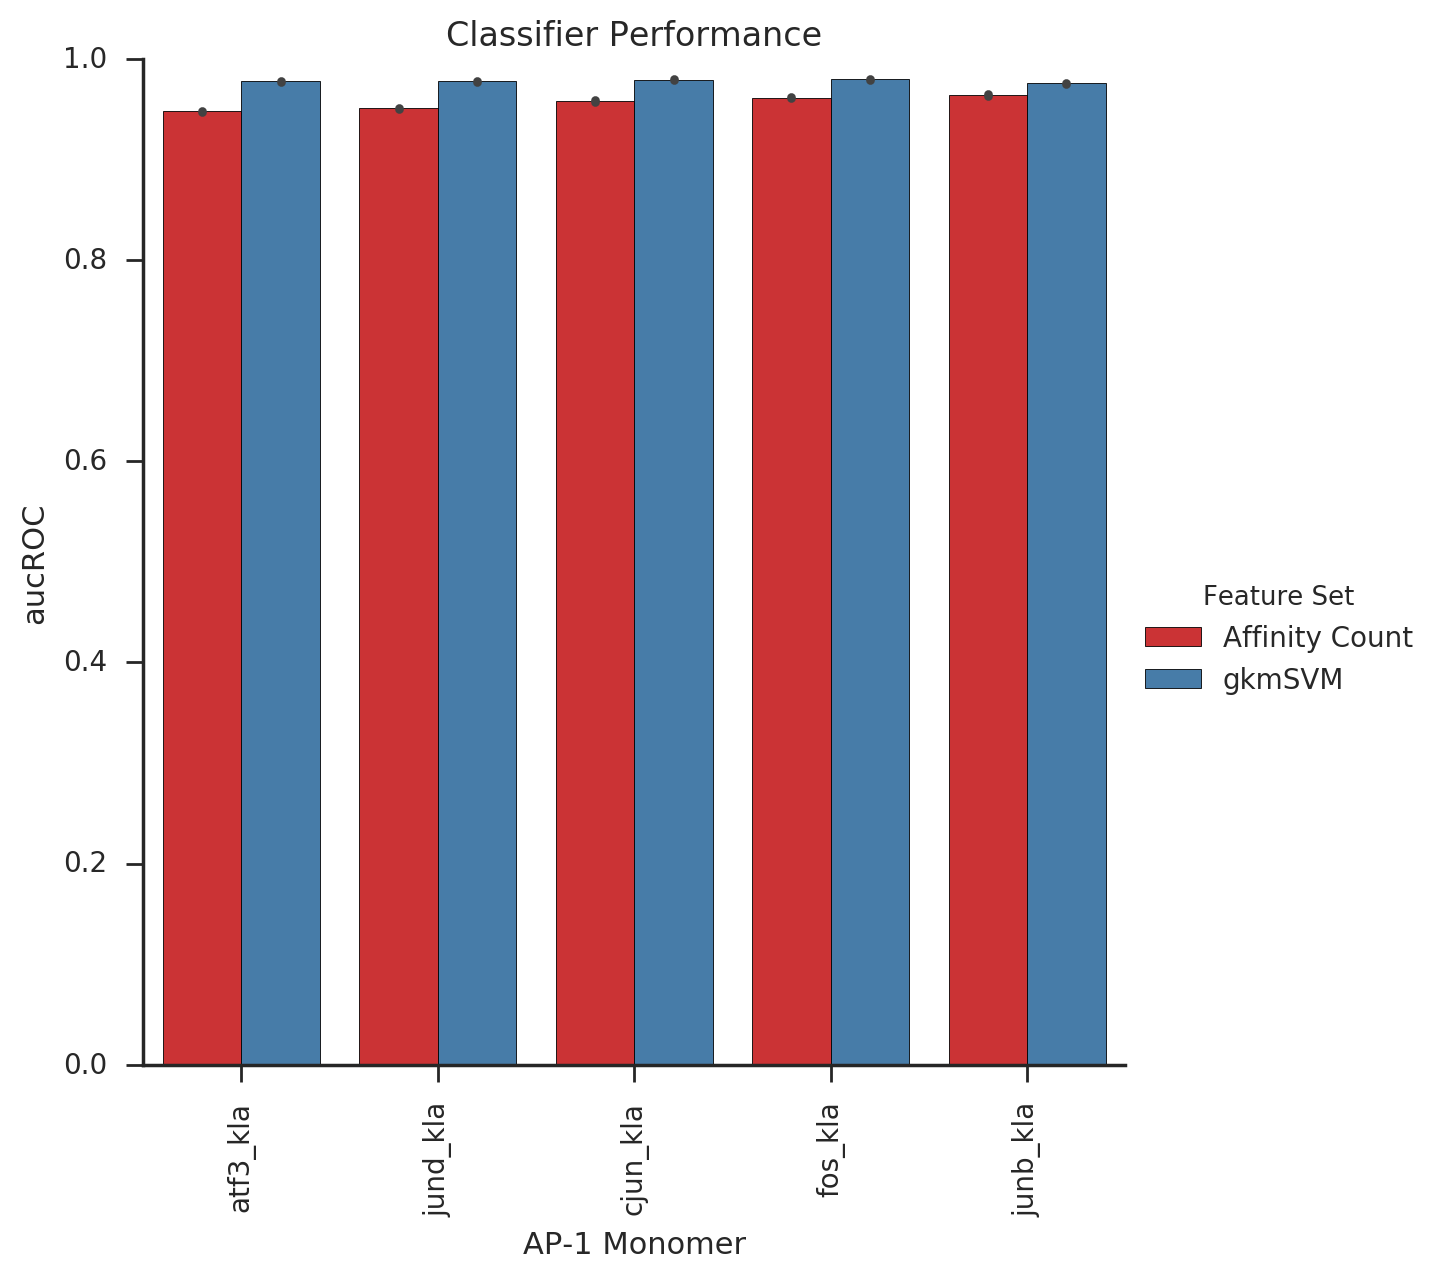

In [328]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_randomBackground_dict.keys()):
#     monomers = monomers + numIterations * [factor]
#     aucs = aucs + factor_auc_randomBackground_dict[factor]
#     feature_set = feature_set + numIterations * ['LR']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_affinityCount[factor]
    feature_set = feature_set + numIterations * ['Affinity Count']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_randomBackground_dict[x])) for x in factor_auc_randomBackground_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.show()

    

### Precision Recall

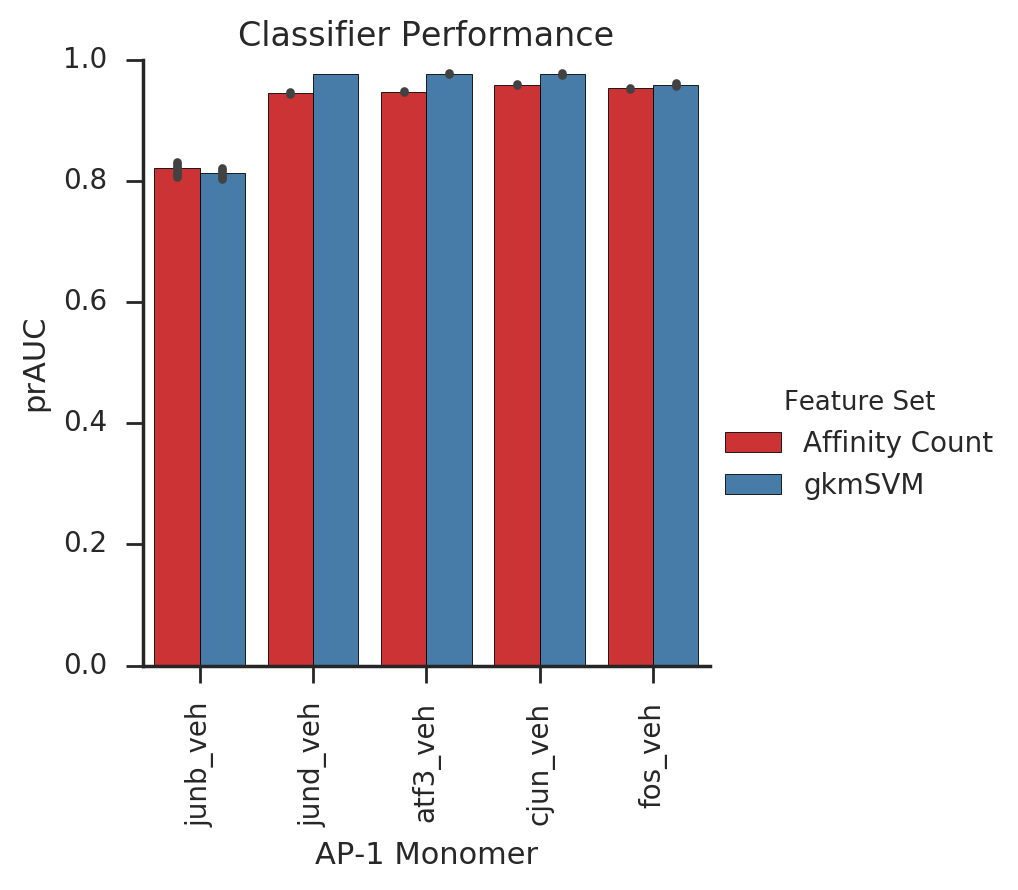

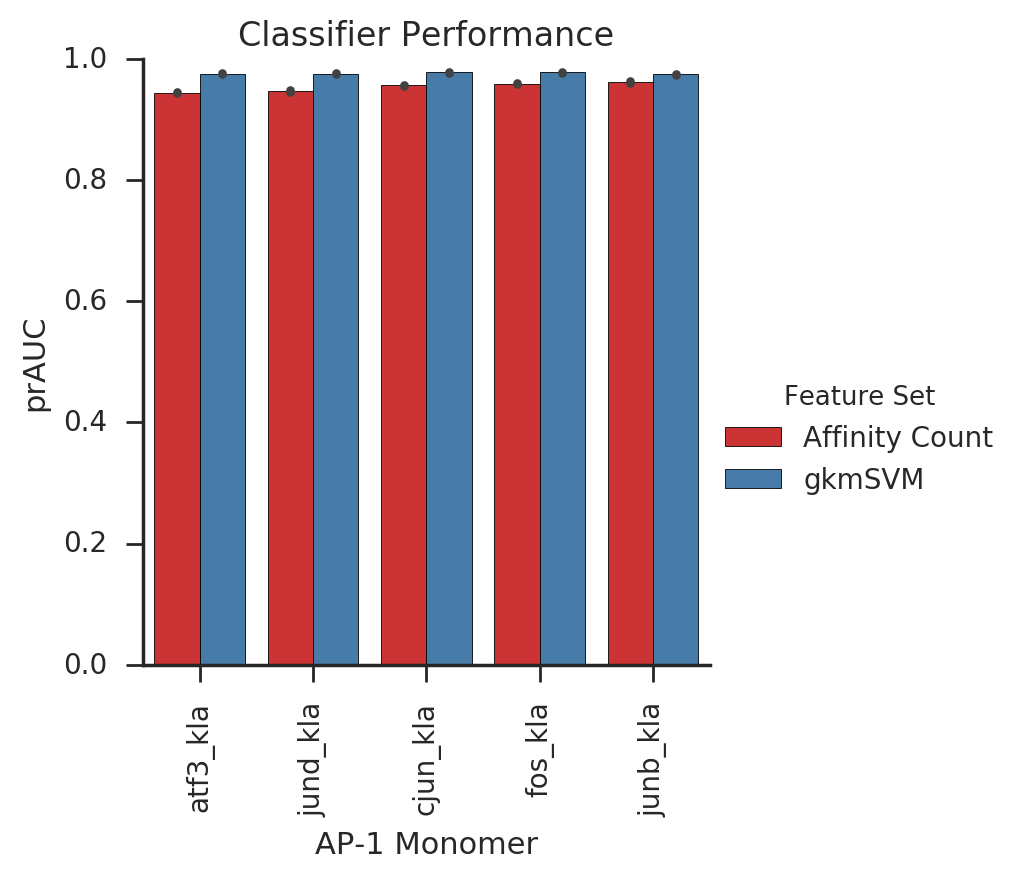

In [329]:
monomers = []
aucs = []
feature_set = []

for factor in sorted(factor_precision_randomBackground_dict.keys()):
#     monomers = monomers + numIterations * [factor]
#     aucs = aucs + factor_precision_randomBackground_dict[factor]
#     feature_set = feature_set + numIterations * ['LR']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_precision_dict_affinityCount[factor]
    feature_set = feature_set + numIterations * ['Affinity Count']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_precision_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'prAUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_precision_randomBackground_dict[x])) for x in factor_precision_randomBackground_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='prAUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=4,
                                    hue='Feature Set',
                                    kind = 'bar'), 
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('prAUC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.show()

    

## Strains Stuff

In [355]:
# for monomers using all motifs
strain = 'balbc'
factor_meanCoeff_randomBackground_balbc_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
#         background_indices = motif_score_background_frame.index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)
        all_aucs = []
        all_coefficients = []
        all_probs = None
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_split(
                features, labels, test_size = test_size)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            all_intercepts.append(lr_classifier.intercept_[0])

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        mean_coefficients = np.mean(all_coefficients, axis=0)

        factor_meanCoeff_randomBackground_balbc_dict[monomer + '_' + treatment] = mean_coefficients
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.927525573619 7.46233363173e-07 precision: 0.925073938731 4.86284930648e-06 numTestPositives: 8678
cjun_veh roc: 0.926046169973 4.97812689571e-06 precision: 0.930623381041 4.90824315145e-06 numTestPositives: 6742
fos_veh roc: 0.963749395044 6.86911752817e-06 precision: 0.965685385075 7.72845050766e-06 numTestPositives: 1229
junb_veh roc: 0.829362880886 0.00219949202354 precision: 0.838362078814 0.00220719518204 numTestPositives: 19
jund_veh roc: 0.887348019719 2.81483950443e-06 precision: 0.892668813941 2.03276247607e-06 numTestPositives: 13697
atf3_kla roc: 0.909382589519 5.52889356594e-07 precision: 0.902820805026 4.81075493319e-07 numTestPositives: 17390
cjun_kla roc: 0.917761347394 6.32800614459e-07 precision: 0.922634749922 1.6578144404e-06 numTestPositives: 7533
fos_kla roc: 0.928447473014 9.21446668075e-07 precision: 0.926417328855 1.00375163765e-06 numTestPositives: 14456
junb_kla roc: 0.940431231763 1.00496027242e-06 precision: 0.939042004537 6.89390798958e-07 n

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


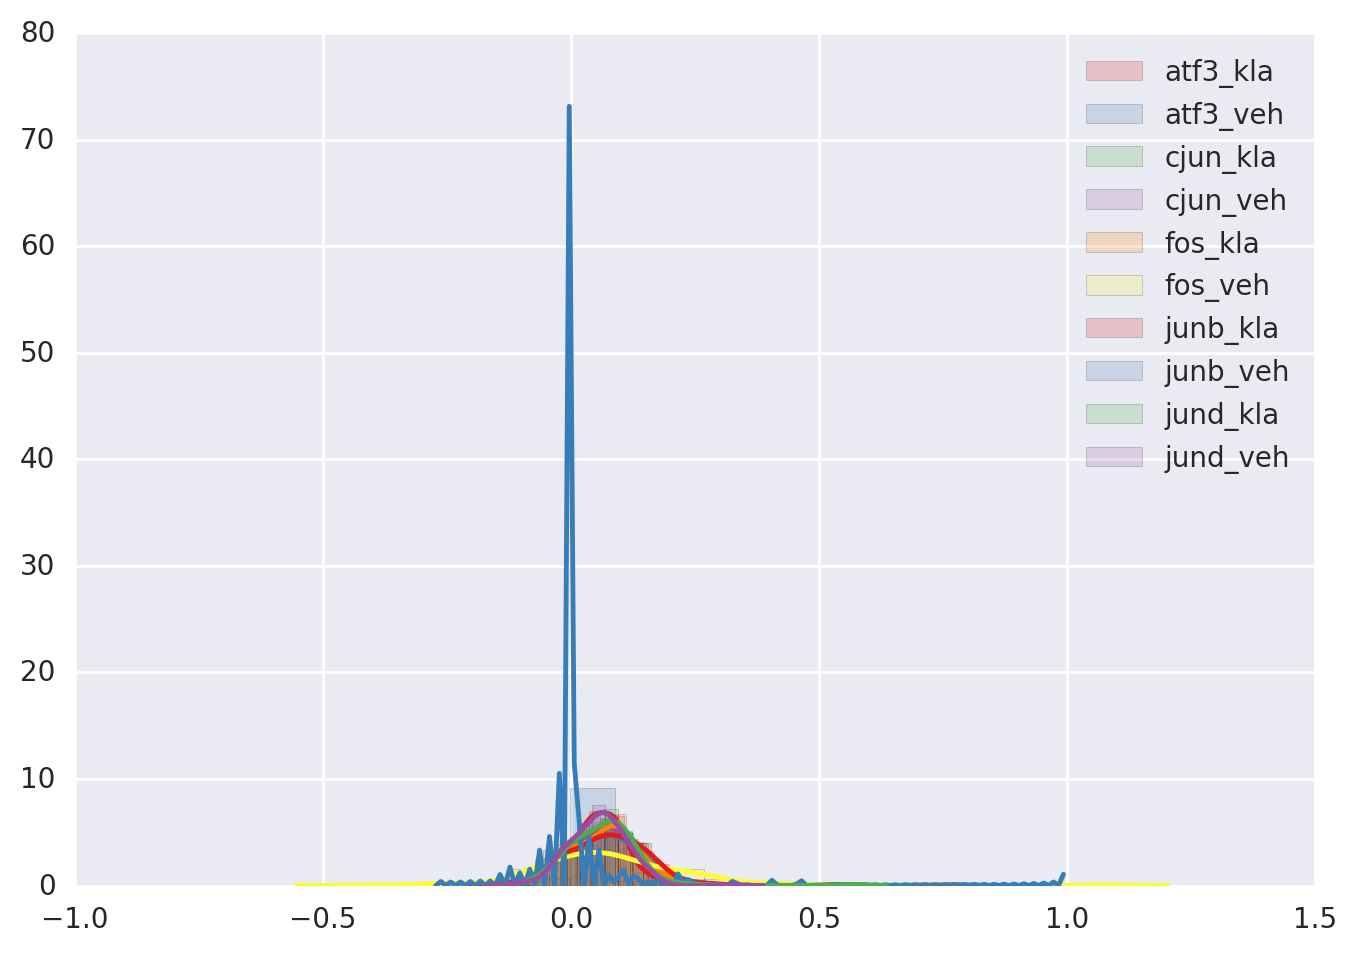

In [358]:
top_motifs_dict = {}
weight_threshold = 1.5
coefficients_randomBackground_balbc_frame = pd.DataFrame(factor_meanCoeff_randomBackground_balbc_dict)
coefficients_randomBackground_balbc_frame.index = standardized_motif_randomBackground_frame.columns.values
for col in coefficients_randomBackground_balbc_frame.columns.values:
    sns.distplot(coefficients_randomBackground_balbc_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_randomBackground_balbc_frame = coefficients_randomBackground_balbc_frame[[]]
for col in coefficients_randomBackground_balbc_frame:
    coefficients_zscore_randomBackground_balbc_frame[col] = scipy.stats.mstats.zscore(coefficients_randomBackground_balbc_frame[col].values)

coefficients_zscore_randomBackground_balbc_frame.index = coefficients_randomBackground_balbc_frame.index.values
coefficients_zscore_randomBackground_balbc_frame.columns = coefficients_randomBackground_balbc_frame.columns.values


### Train on C57BL6 test on BALBC

In [424]:
# for monomers using motif counts and best motif score
strain1 = 'c57bl6'
strain2 = 'balbc'
factor_auc_c57bl6Trained_dict = {}
factor_precision_c57bl6Trained_dict = {}
weight_threshold = 1.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        data = coefficients_zscore_randomBackground_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs = data.index.values
        target_indices = summary_frame[summary_frame[strain1 + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)

        # get data for other strain
        target_indices_strain2 = summary_frame[summary_frame[strain2 + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_affinity_features_strain2 = standardized_BALBCJ_motif_frame[standardized_BALBCJ_motif_frame.index.isin(target_indices_strain2)]

        # merge target and background features together 
        affinity_features_strain2 = pd.concat([target_affinity_features_strain2, background_affinity_features])
        affinity_features_strain2 = affinity_features_strain2[top_motifs]
        labels_strain2 = pd.Series(data = [True] * len(target_indices_strain2) + [False] * len(background_indices),
                           index = affinity_features_strain2.index.values)
        
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  

            # split data into training and test sets seperately for each strain
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_affinity_features_strain2, test_affinity_features_strain2, training_labels_strain2, test_labels_strain2 = get_split(
                affinity_features_strain2, labels_strain2, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])

            training_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs]])
            test_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features_strain2)
            test_count_scores = count_classifier.decision_function(test_count_features_strain2)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels_strain2, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels_strain2, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_c57bl6Trained_dict[monomer + '_' + treatment] = all_aucs
        factor_precision_c57bl6Trained_dict[monomer + '_' + treatment] = all_precisions
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.946993162578 9.12825087785e-07 precision: 0.928868269686 3.46862492367e-06 numTestPositives: 11013
cjun_veh roc: 0.931034399681 1.39049158331e-06 precision: 0.934260557246 1.61689281115e-06 numTestPositives: 6335
fos_veh roc: 0.93069400946 2.95455030065e-05 precision: 0.940703033189 2.25162730322e-05 numTestPositives: 994
junb_veh roc: 0.876454293629 0.00126681095914 precision: 0.481654738159 0.00865404641873 numTestPositives: 247
jund_veh roc: 0.90241480867 4.99250001285e-06 precision: 0.929078596514 1.75385935407e-06 numTestPositives: 9025
atf3_kla roc: 0.922786027039 9.73620547335e-07 precision: 0.916130445608 2.36702447613e-06 numTestPositives: 17327
cjun_kla roc: 0.92086450423 2.80096966549e-06 precision: 0.916411215377 2.02237113555e-06 numTestPositives: 8068
fos_kla roc: 0.911350207437 1.73192289149e-06 precision: 0.926461847973 2.63047488923e-06 numTestPositives: 10733
junb_kla roc: 0.936996459222 2.03813409419e-06 precision: 0.950083891714 1.86131915603e-06 num

### Train on BALBC test on C57BL6J

In [429]:
# for monomers using motif counts and best motif score
strain1 = 'c57bl6'
strain2 = 'balbc'
factor_auc_c57bl6Trained_dict = {}
factor_precision_c57bl6Trained_dict = {}
weight_threshold = 1.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        data = coefficients_zscore_randomBackground_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs = data.index.values
        target_indices = summary_frame[summary_frame[strain1 + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)

        # get data for other strain
        target_indices_strain2 = summary_frame[summary_frame[strain2 + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_affinity_features_strain2 = standardized_BALBCJ_motif_frame[standardized_BALBCJ_motif_frame.index.isin(target_indices_strain2)]

        # merge target and background features together 
        affinity_features_strain2 = pd.concat([target_affinity_features_strain2, background_affinity_features])
        affinity_features_strain2 = affinity_features_strain2[top_motifs]
        labels_strain2 = pd.Series(data = [True] * len(target_indices_strain2) + [False] * len(background_indices),
                           index = affinity_features_strain2.index.values)
        
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  

            # split data into training and test sets seperately for each strain
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_affinity_features_strain2, test_affinity_features_strain2, training_labels_strain2, test_labels_strain2 = get_split(
                affinity_features_strain2, labels_strain2, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])

            training_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs]])
            test_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features_strain2, training_labels_strain2)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features_strain2, training_labels_strain2)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features_strain2)
            training_count_scores = count_classifier.decision_function(training_count_features_strain2)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels_strain2)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_c57bl6Trained_dict[monomer + '_' + treatment] = all_aucs
        factor_precision_c57bl6Trained_dict[monomer + '_' + treatment] = all_precisions
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.936917084915 1.473913697e-07 precision: 0.933383081118 7.85216757841e-07 numTestPositives: 11013
cjun_veh roc: 0.935959431604 2.40849168265e-06 precision: 0.933162592112 5.38096714512e-06 numTestPositives: 6335
fos_veh roc: 0.937091361044 2.67214410056e-05 precision: 0.931246976648 4.07082078653e-05 numTestPositives: 994
junb_veh roc: 0.788834434264 0.000309243409215 precision: 0.795287036758 0.000542218214073 numTestPositives: 247
jund_veh roc: 0.930630992703 1.3024867676e-06 precision: 0.922622695389 1.89242410325e-06 numTestPositives: 9025
atf3_kla roc: 0.921024642827 1.97031841242e-06 precision: 0.91321526336 2.53896143457e-06 numTestPositives: 17327
cjun_kla roc: 0.937679135504 2.99404748286e-06 precision: 0.934389264808 5.49118620656e-06 numTestPositives: 8068
fos_kla roc: 0.92623151748 5.95680597659e-07 precision: 0.919700310129 2.32671985014e-06 numTestPositives: 10733
junb_kla roc: 0.94772445603 5.66306167424e-06 precision: 0.945311217441 6.31985390686e-06 numT

### Copy Data Files

In [376]:
! cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/merged_annotated_peaks_ap1TagCounts.tsv ./

### Read in Tag Counts Frame

In [402]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('./merged_annotated_peaks_ap1TagCounts.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[0:5]).split('-')[0] for x in columns]))

ap1_meanTag_dict = {}
for ft in factor_treatments:
    ap1_meanTag_dict[ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1).values
ap1_meanTag_frame = pd.DataFrame(ap1_meanTag_dict)
ap1_meanTag_frame = ap1_meanTag_frame[factor_treatments]
ap1_meanTag_frame.columns = [x.replace('_Thiomac_ChIP','').lower() for x in ap1_meanTag_frame.columns.values]
ap1_meanTag_frame.index = ap1_tag_frame.index.values

## Plot Classifier Score Differences and Tag Count Differences

In [403]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [454]:
# for monomers using motif counts and best motif score
strain1 = 'c57bl6'
strain2 = 'balbc'
fold_threshold = 4.0
factor_auc_balbcTrained_dict = {}
factor_precision_balbcTrained_dict = {}
weight_threshold = 1.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[(summary_frame[strain1 + '_' + monomer + '_' + treatment] > 0.0) |
                                       (summary_frame[strain2 + '_' + monomer + '_' + treatment] > 0.0)].index.values
        
        tags_strain1 = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(target_indices)][strain1 + '_' + monomer + '_' + treatment]
        tags_strain2 = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(target_indices)][strain2 + '_' + monomer + '_' + treatment]
        fold_changes = tags_strain1 / tags_strain2
        strain_specific_indices = fold_changes[(fold_changes >= fold_threshold) | (fold_changes <= 1/fold_threshold)].index.values
        print(monomer, treatment, len(strain_specific_indices))
        
        
        data = coefficients_zscore_randomBackground_balbc_frame
        data = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ]
        top_motifs = data.index.values

        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(strain_specific_indices))]

        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(strain_specific_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        labels = pd.Series(data = [True] * len(strain_specific_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)

        # get data for other strain
        target_affinity_features_strain2 = standardized_BALBCJ_motif_frame[standardized_BALBCJ_motif_frame.index.isin(strain_specific_indices)]

        # merge target and background features together 
        affinity_features_strain2 = pd.concat([target_affinity_features_strain2, background_affinity_features])
        affinity_features_strain2 = affinity_features_strain2[top_motifs]
        labels_strain2 = pd.Series(data = [True] * len(strain_specific_indices) + [False] * len(background_indices),
                           index = affinity_features_strain2.index.values)
        
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        all_probs = []
        for i in range(numIterations):  

            # split data into training and test sets seperately for each strain
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_affinity_features_strain2, test_affinity_features_strain2, training_labels_strain2, test_labels_strain2 = get_split(
                affinity_features_strain2, labels_strain2, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])

            training_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features_strain2.index.values)][top_motifs]])
            test_count_features_strain2 = pd.concat([motif_count_BALBCJ_frame[motif_count_BALBCJ_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features_strain2.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features_strain2)
            test_count_scores = count_classifier.decision_function(test_count_features_strain2)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all peaks
            count_features = pd.concat([training_count_features, test_count_features])
            count_features_strain2 = pd.concat([training_count_features_strain2, test_count_features_strain2])
            
            affinity_scores = affinity_classifier.decision_function(affinity_features)
            count_scores = count_classifier.decision_function(count_features)
            
            affinity_scores_strain2 = affinity_classifier.decision_function(affinity_features_strain2)
            count_scores_strain2 = count_classifier.decision_function(count_features_strain2)
            
            
            combined_features = pd.DataFrame({'Affinity':affinity_scores,
                                                       'Count':count_scores})
            combined_features_strain2 = pd.DataFrame({'Affinity':affinity_scores_strain2,
                                                       'Count':count_scores_strain2})
            
            all_probs_strain1 = combined_classifier.predict_proba(combined_features)
            all_probs_strain2 = combined_classifier.predict_proba(combined_features_strain2)
            print(len(all_probs_strain1), len(all_probs_strain2), len(strain_specific_indices))
#             prob_differences = all_probs_strain1 - all_probs_strain2
#             plt.scatter(fold_changes[fold_changes.index.isin(strain_specific_indices)], prob_differences)
#             plt.xlabel('Fold Change')
#             plt.ylabel('Delta Classifier Score')
#             plt.title(monomer + '_' + treatment)
            break
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )
                

atf3 veh 1056


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2112 2112 1056
atf3_veh roc: 0.924848628329 0.0 precision: 0.923906158522 0.0 numTestPositives: 528
cjun veh 1274
2548 2548 1274
cjun_veh roc: 0.895541551967 0.0 precision: 0.879445820593 0.0 numTestPositives: 637
fos veh 940
1880 1880 940
fos_veh roc: 0.959981892259 0.0 precision: 0.957699042632 0.0 numTestPositives: 470
junb veh 316
632 632 316
junb_veh roc: 0.869852587726 0.0 precision: 0.875305648965 0.0 numTestPositives: 158
jund veh 1111
2222 2222 1111
jund_veh roc: 0.926304280317 0.0 precision: 0.90256540769 0.0 numTestPositives: 556
atf3 kla 1704
3408 3408 1704
atf3_kla roc: 0.909898554079 0.0 precision: 0.908071446798 0.0 numTestPositives: 852
cjun kla 1033
2066 2066 1033
cjun_kla roc: 0.87922436015 0.0 precision: 0.86716297694 0.0 numTestPositives: 517
fos kla 5930
11860 11860 5930
fos_kla roc: 0.930374094623 0.0 precision: 0.933272905976 0.0 numTestPositives: 2965
junb kla 2134
4268 4268 2134
junb_kla roc: 0.926268062318 0.0 precision: 0.937702090915 0.0 numTestPositives: 10

In [436]:
all_coefficients

[]

In [434]:
coefficients

nan

In [384]:
ap1_meanTag_frame.shape

(105061, 32)

In [375]:

factor_treatments

['balbc_atf3_kla',
 'balbc_atf3_veh',
 'balbc_cjun_kla',
 'balbc_cjun_veh',
 'balbc_fos_kla',
 'balbc_fos_veh',
 'balbc_junb_kla',
 'balbc_junb_veh',
 'balbc_jund_kla',
 'balbc_jund_veh',
 'balbc_p65_kla',
 'balbc_p65_veh',
 'balbc_pu1_kla',
 'balbc_pu1_veh',
 'c57bl6_atf3_kla',
 'c57bl6_atf3_veh',
 'c57bl6_cebpa_kla',
 'c57bl6_cebpa_veh',
 'c57bl6_cjun_kla',
 'c57bl6_cjun_veh',
 'c57bl6_fos_kla',
 'c57bl6_fos_veh',
 'c57bl6_fra2_kla',
 'c57bl6_fra2_veh',
 'c57bl6_junb_kla',
 'c57bl6_junb_veh',
 'c57bl6_jund_kla',
 'c57bl6_jund_veh',
 'c57bl6_p65_kla',
 'c57bl6_p65_veh',
 'c57bl6_pu1_kla',
 'c57bl6_pu1_veh']